## Importing Dependency Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [4]:
storage = {
    "model": None,
    "scaler": None,
    "means": None
}

## Loading the Dataset

In [5]:
columns = ['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall']

In [6]:
# Detect outliers in numerical columns
numeric_columns = ['AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA', 'AgeAtCalvingInDays',
       'AgeAtCalvingInMonths', 'MostRecentBodyScore', 'MostRecentMotionScore',
       'AverageBodyScore', 'AverageMotionScore', 'InbreedingCoefficient',
       'PregnancyLengthMonths', 'Milk',
       'MilkDays', 'MilkFat', 'MilkProtein',
       'DIMAtBreeding', 'Lactation',
       'LengthInDays', 'DaysOpen', 'TimesBred', 'AverageMilk', 'ECM',
       'FatProteinRatio']

good_features = ['Serial', 'AgeAtCalvingInDays', 'AverageBodyScore',
       'AverageMotionScore', 'InbreedingCoefficient', 'StillBirth', 'Abortion',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'DaysOpen', 'TimesBred',
       'Lameness', 'Mastitis', 'Ketosis', 'RetainedPlacenta',
       'DisplacedAbomasum', 'Winter', 'Spring', 'Summer', 'Fall',
       'AverageMilk', 'ECM', 'FatProteinRatio']

In [7]:
# Use the Pandas library to read the CSV file
data = pd.read_csv('days-open-v9.csv', dtype= {'Serial': str}, names= columns)

## Analyzing the Data

In [8]:
data['Serial'].nunique()

5557

In [9]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall'],
      dtype='object')

In [10]:
data['AverageMotionScore'].describe()

count    5444.000000
mean        2.104669
std         0.810585
min         1.000000
25%         1.500000
50%         2.000000
75%         2.500000
max         5.000000
Name: AverageMotionScore, dtype: float64

## Data Validation

In [11]:
def remove_invalid_records(data, condition):
    # Find invalid records based on the condition
    invalid_records = data[~condition]
    
    # Get the serial numbers of invalid records
    invalid_serials = invalid_records['Serial'].unique()
    
    # Remove all records with the same serial numbers
    cleaned_data = data[~data['Serial'].isin(invalid_serials)]
    
    return cleaned_data

# Example usage:
# Define your condition
condition = (
    (data['AgeAtCalvingInMonthsA'] > 20) &
    (data['AgeAtCalvingInMonths'] > 20) &
    (data['DaysOpen'] > 60) 
)

# Call the function
cleaned_data = remove_invalid_records(data, condition)


In [12]:
data['Serial'].nunique()

5557

In [13]:
cleaned_data

,Serial,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,...,TimesBred,Lameness,Mastitis,Ketosis,RetainedPlacenta,DisplacedAbomasum,Winter,Spring,Summer,Fall
8,3251370020200020,1661,55,2090,69,NaN,NaN,NaN,NaN,0.000000,...,1,0,0,0,0,0,1,0,0,0
9,3251370022700030,1499,49,1942,64,NaN,NaN,NaN,NaN,0.000000,...,3,0,0,0,0,0,0,0,1,1
10,3251370022700030,1942,64,2432,80,NaN,NaN,NaN,NaN,0.000000,...,4,0,0,0,0,0,1,0,0,0
11,3251370022700030,2432,80,2812,92,NaN,NaN,NaN,NaN,0.000000,...,2,0,0,0,0,0,1,0,0,0
12,3251370022700030,2812,92,3298,108,NaN,NaN,NaN,NaN,0.000000,...,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16457,3251393101906930,1009,33,1382,45,4.00,3.0,4.175000,2.5,NaN,...,1,0,0,0,0,0,0,0,0,1
16458,3251389081106010,1488,48,1722,56,4.00,4.0,4.178571,4.0,4.199220,...,2,0,0,0,0,0,0,0,1,0
16462,3251391022301370,726,24,1073,35,4.00,NaN,4.250000,NaN,NaN,...,3,0,0,0,0,0,0,1,0,0
16467,3251388033002190,1991,66,2277,75,3.50,NaN,4.305556,NaN,0.720215,...,3,0,0,0,1,0,0,0,1,1


In [14]:
# logical_data = logical_data[(logical_data['DaysOpen'] >= 70) & (logical_data['DaysOpen'] <= 365)]
cleaned_data.shape

(7639, 33)

In [15]:
data = cleaned_data

## Data Processing
In this part we use process the data, merge it disorders data and then clean the data, remove the outliers and normalize it to be ready for the model

In [16]:
data['AverageMilk'] = data['Milk'] / data['MilkDays']

In [17]:
mask = np.isnan(data["MilkFat"]) | np.isnan(data["MilkProtein"]) | np.isnan(data["Milk"])

data["ECM"] = np.nan
data.loc[~mask, "ECM"] = 0.327 * data["Milk"] + 12.95 * data["MilkFat"] + 7.65 * data["MilkProtein"]



In [18]:

data["FatProteinRatio"] = np.nan
data.loc[~mask, "FatProteinRatio"] = data["MilkFat"] / data["MilkProtein"]


## Creating a table for features

In [19]:
feature_descriptions = {
    'AgeAtCalvingInDaysA': 'Age at calving in days (Category A)',
    'AgeAtCalvingInMonthsA': 'Age at calving in months (Category A)',
    'AgeAtCalvingInDays': 'Age at calving in days',
    'AgeAtCalvingInMonths': 'Age at calving in months',
    'MostRecentBodyScore': 'Most recent body score',
    'MostRecentMotionScore': 'Most recent motion score',
    'AverageBodyScore': 'Average body score',
    'AverageMotionScore': 'Average motion score',
    'InbreedingCoefficient': 'Inbreeding coefficient',
    'PregnancyLengthMonths': 'Pregnancy length in months',
    'Milk': 'Milk yield',
    'MilkDays': 'Days of milk production',
    'MilkFat': 'Milk fat content',
    'MilkProtein': 'Milk protein content',
    'StillBirth': 'Still birth (0 or 1)',
    'Abortion': 'Abortion (0 or 1)',
    'DIMAtBreeding': 'Days in milk at breeding',
    'Lactation': 'Lactation number',
    'MultiBirth': 'Multiple birth (0 or 1)',
    'NaturalBreeding': 'Natural breeding (0 or 1)',
    'LengthInDays': 'Length in days',
    'DaysOpen': 'Days open',
    'TimesBred': 'Number of times bred',
    'Lameness': 'Lameness score',
    'Mastitis': 'Mastitis score',
    'Ketosis': 'Ketosis score',
    'RetainedPlacenta': 'Retained placenta (0 or 1)',
    'DisplacedAbomasum': 'Displaced abomasum (0 or 1)',
    'Winter': 'Winter season (0 or 1)',
    'Spring': 'Spring season (0 or 1)',
    'Summer': 'Summer season (0 or 1)',
    'Fall': 'Fall season (0 or 1)',
    'AverageMilk': 'Average milk yield',
    'ECM': 'Energy-corrected milk yield',
    'FatProteinRatio': 'Fat to protein ratio'
}

In [20]:


def categorize_feature_type(series):
    if series.nunique() == 2 and (0 in series.unique()) and (1 in series.unique()):
        return 'Binary'
    elif np.issubdtype(series.dtype, np.number):
        return 'Numeric'
    else:
        return 'Nominal'

def generate_feature_description_table(data):
    # Calculate % of missing values
    missing_percentage = (data.isnull().sum() / len(data)) * 100

    # Get data types
    data_types = data.apply(categorize_feature_type)


    # Calculate summary statistics
    summary_stats = data.describe().transpose()

    # Combine all information into a table
    feature_table = pd.concat([summary_stats, missing_percentage, data_types], axis=1)
    feature_table.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', '% Missing', 'Data Type']
    feature_table['Description'] = feature_table.index.map(feature_descriptions)

    return feature_table


In [21]:
stat = generate_feature_description_table(data[good_features])
stat.to_csv('features.csv')

## Handling outliers

In [22]:

outliers = data[numeric_columns].apply(lambda x: (x - x.mean()).abs() > 3 * x.std())
outlier_counts = outliers.sum()

outlier_counts


AgeAtCalvingInDaysA      112
AgeAtCalvingInMonthsA    113
AgeAtCalvingInDays       114
AgeAtCalvingInMonths     114
MostRecentBodyScore       28
MostRecentMotionScore      0
AverageBodyScore          38
AverageMotionScore        21
InbreedingCoefficient     99
PregnancyLengthMonths    311
Milk                       9
MilkDays                  26
MilkFat                   13
MilkProtein                8
DIMAtBreeding            177
Lactation                 79
LengthInDays             127
DaysOpen                 177
TimesBred                 84
AverageMilk                4
ECM                       13
FatProteinRatio            4
dtype: int64

In [23]:
standard_data = data.copy()  # Create a copy of the original DataFrame
# Handling outliers
for column in numeric_columns:
    mean = standard_data[column].mean()
    std = standard_data[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std

    standard_data.loc[:, column] = standard_data.loc[:, column].clip(lower=lower_bound, upper=upper_bound)



## Filling missing values

In [24]:
# Check the number of missing values in each column
missing_values_count = standard_data.isnull().sum()
print(missing_values_count)


Serial                      0
AgeAtCalvingInDaysA         0
AgeAtCalvingInMonthsA       0
AgeAtCalvingInDays          0
AgeAtCalvingInMonths        0
MostRecentBodyScore      1990
MostRecentMotionScore    5051
AverageBodyScore         1990
AverageMotionScore       5051
InbreedingCoefficient    3788
PregnancyLengthMonths       0
Milk                     5948
MilkDays                 5948
MilkFat                  5948
MilkProtein              5948
StillBirth                  0
Abortion                    0
DIMAtBreeding               0
Lactation                   0
MultiBirth                  0
NaturalBreeding             0
LengthInDays                0
DaysOpen                    0
TimesBred                   0
Lameness                    0
Mastitis                    0
Ketosis                     0
RetainedPlacenta            0
DisplacedAbomasum           0
Winter                      0
Spring                      0
Summer                      0
Fall                        0
AverageMil

In [25]:
import pandas as pd

filled_data = standard_data.copy()  # Create a copy of the original DataFrame


mean_values = {}  # Dictionary to store the mean values

# fill NaN values with mean value of each column
for col in numeric_columns:
    mean_val = filled_data[col].mean()
    mean_values[col] = mean_val  # Save the mean value for each column
    filled_data[col].fillna(mean_val, inplace=True)

storage["means"] = mean_values

In [26]:
# # To have good features
filled_data = filled_data[good_features]


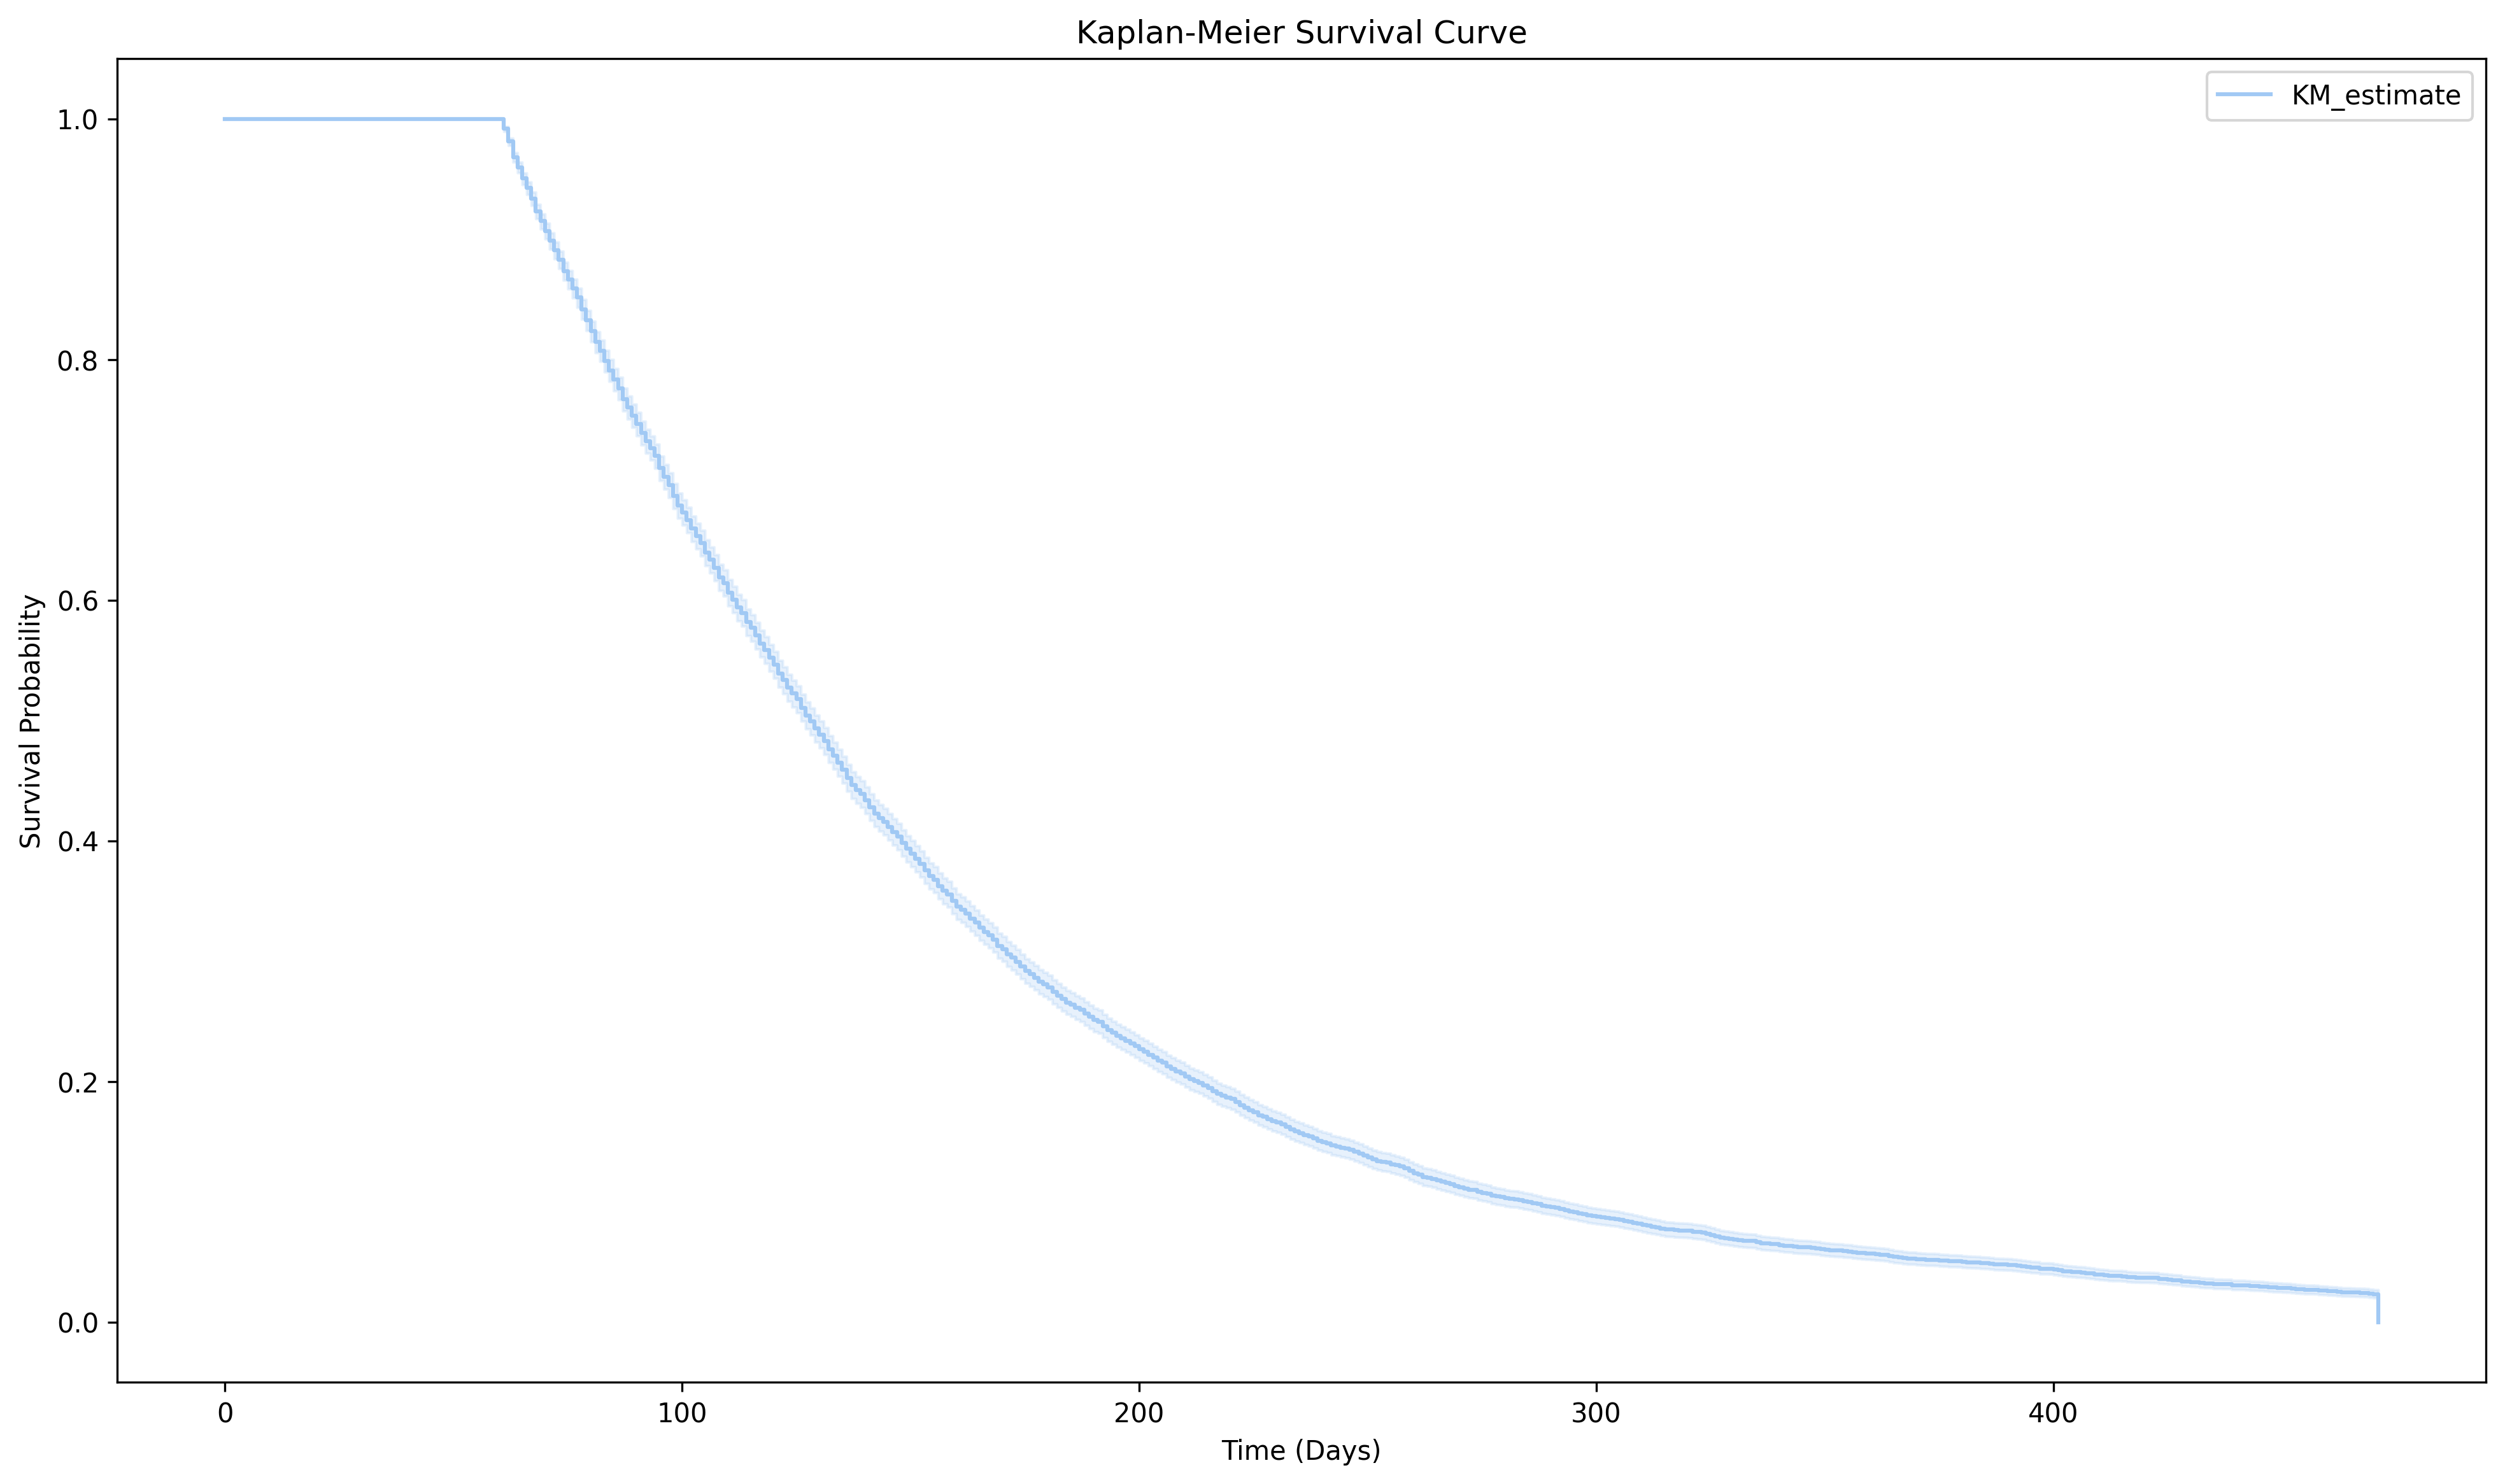

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator to your data
kmf.fit(durations=cox_data['DaysOpen'], event_observed=cox_data['Event'])

# Set the figure size and dpi
plt.figure(figsize=(16, 9), dpi=300)

# Set the color palette
sns.set_palette("pastel")

# Plot the Kaplan-Meier survival curve
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.show()



In [70]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


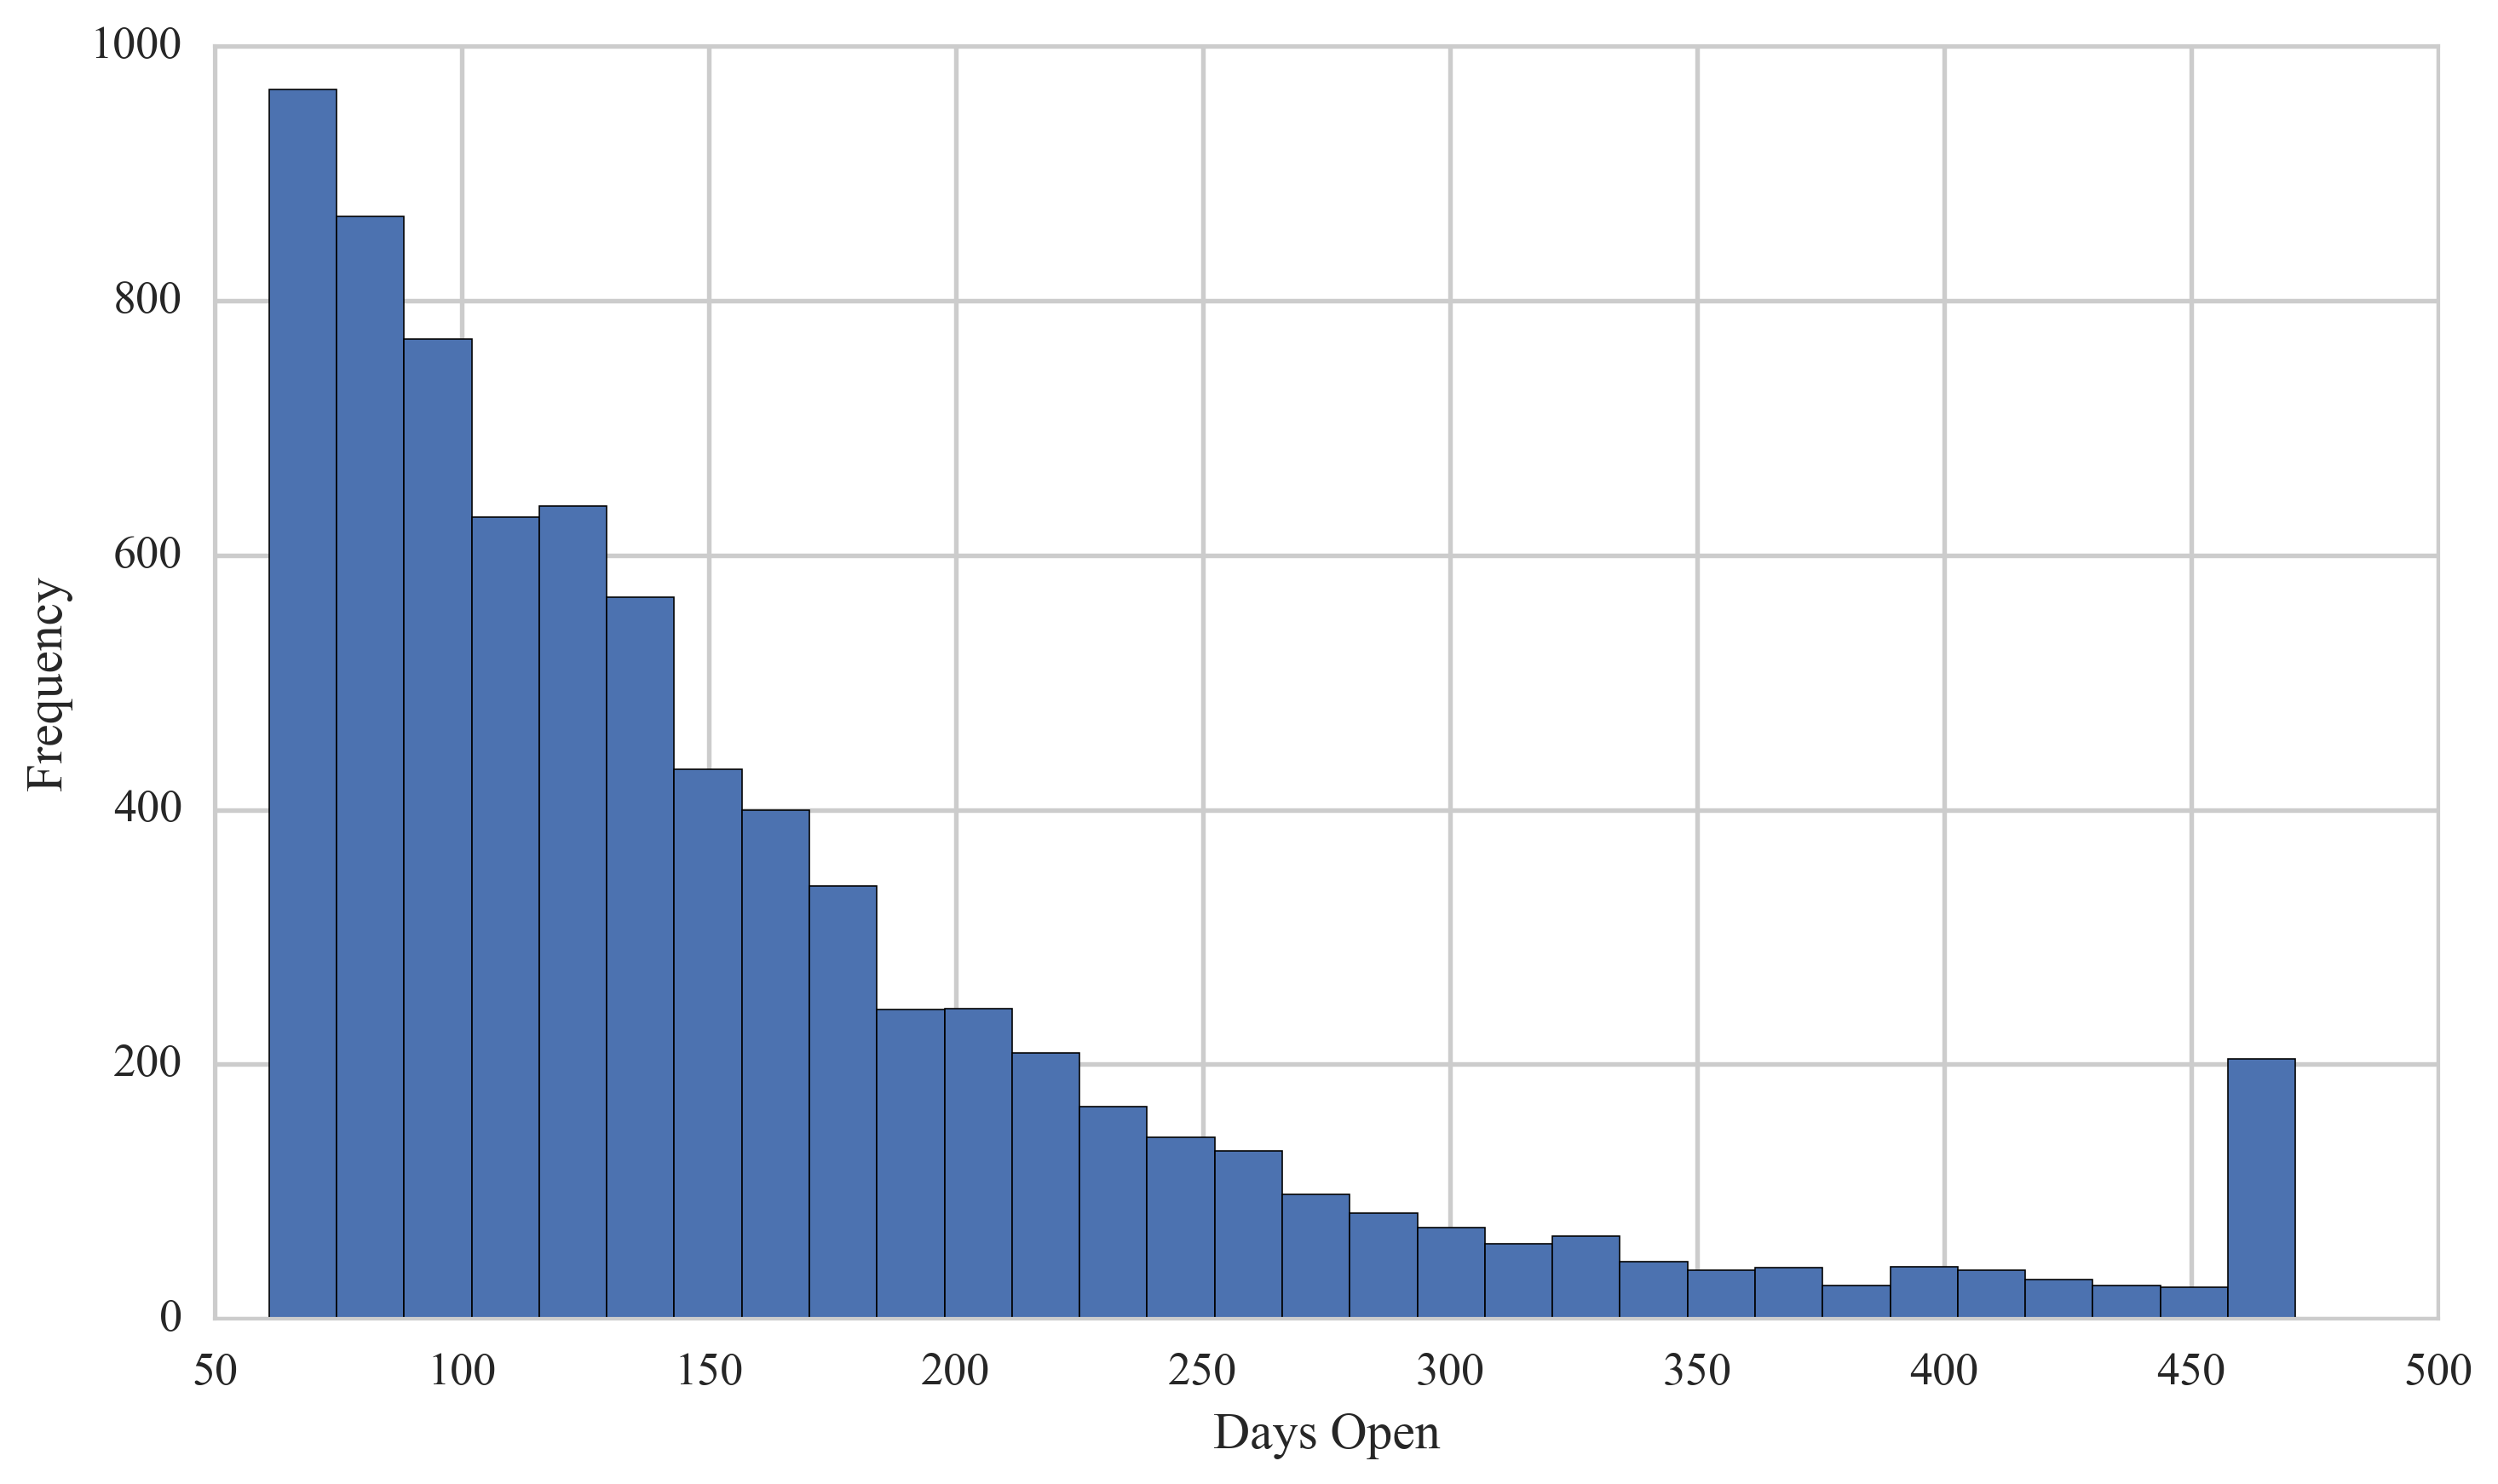

In [147]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6), dpi=300)
plt.hist(filled_data['DaysOpen'], bins=30)
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.savefig('days_open_histogram.svg', format='svg', dpi=300)
plt.show()


In [83]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# Set the dark theme
pio.templates.default = "plotly_dark"

In [84]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['DaysOpen'], name='Days Open', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='Days Open Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='Days Open', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [85]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['AgeAtCalvingInDays'], name='AgeAtCalvingInDays', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='AgeAtCalvingInDays Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='AgeAtCalvingInDays', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [86]:
# # Seasons Pie Chart
# season_counts = filled_data[['Winter', 'Spring', 'Summer', 'Fall']].sum()
# fig = go.Figure(data=[go.Pie(labels=season_counts.index, values=season_counts.values)])
# fig.update_layout(
#     title='Seasons Pie Chart',
#     font=dict(color='white'),  # Set font color
# )
# fig.show()

In [87]:
# import plotly.figure_factory as ff
# import numpy as np

# # Select numeric columns for correlation matrix
# numeric_columns = filled_data.select_dtypes(include=[np.number])

# # Compute correlation matrix
# corr_matrix = numeric_columns.corr()

# # Format correlation values with desired precision
# corr_values = corr_matrix.apply(lambda x: np.round(x, 2)).values.tolist()

# # Convert correlation matrix columns to a list
# corr_columns = corr_matrix.columns.tolist()

# # Create the correlation heatmap
# fig = ff.create_annotated_heatmap(
#     z=corr_values,
#     x=corr_columns,
#     y=corr_columns,
#     colorscale='Viridis',
#     colorbar=dict(title='Correlation'),
# )

# # Update layout
# fig.update_layout(
#     title='Correlation Heatmap',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(tickfont=dict(color='white')),  # Set x-axis tick font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
#     height=1500,  # Set the height of the figure
#     width=1500,  # Set the width of the figure
# )

# fig.show()


In [88]:
len(filled_data['Serial'].unique())

3147

In [89]:
columns = filled_data.columns.to_list()
columns_to_remove = ['Serial', 'Lactation']  # Columns to remove from the sequence
feature_columns = [col for col in columns if col not in columns_to_remove]

In [90]:
feature_columns

['AgeAtCalvingInDays',
 'AverageBodyScore',
 'AverageMotionScore',
 'InbreedingCoefficient',
 'StillBirth',
 'Abortion',
 'MultiBirth',
 'NaturalBreeding',
 'DaysOpen',
 'TimesBred',
 'Lameness',
 'Mastitis',
 'Ketosis',
 'RetainedPlacenta',
 'DisplacedAbomasum',
 'Winter',
 'Spring',
 'Summer',
 'Fall',
 'AverageMilk',
 'ECM',
 'FatProteinRatio']

## Generating Sequences

In [91]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def generate_sequences(data, feature_cols, target_column, cow_serials):
    sequences = []
    targets = []
    seq_lengths = []

    for cow_serial in cow_serials:
        cow_data = data[data['Serial'] == cow_serial].values
        cow_data = cow_data[np.argsort(cow_data[:, columns.index('Lactation')])]

        for start_index in range(len(cow_data)):
            for end_index in range(start_index + 1, len(cow_data) + 1):
                seq_data = cow_data[start_index:end_index]
                targets.append(seq_data[-1, columns.index(target_column)])

                seq_data = np.delete(seq_data, [columns.index(col) for col in columns_to_remove], axis=1)

                sequences.append(seq_data)
                seq_lengths.append(len(seq_data))

    return sequences, targets, seq_lengths

def split_data(data, validation_ratio=0.1, test_ratio=0.2, seed=0):
    np.random.seed(seed)
    unique_serials = data['Serial'].unique()
    np.random.shuffle(unique_serials)

    num_samples = len(unique_serials)
    num_validation = int(num_samples * validation_ratio)
    num_test = int(num_samples * test_ratio)

    validation_serials = unique_serials[:num_validation]
    test_serials = unique_serials[num_validation:num_validation + num_test]
    train_serials = unique_serials[num_validation + num_test:]

    train_sequences, train_targets, seq_len_train = generate_sequences(data, feature_columns, 'DaysOpen', train_serials)
    val_sequences, val_targets, seq_len_val = generate_sequences(data, feature_columns, 'DaysOpen', validation_serials)
    test_sequences, test_targets, seq_len_test = generate_sequences(data, feature_columns, 'DaysOpen', test_serials)

    return train_sequences, train_targets, seq_len_train, val_sequences, val_targets, seq_len_val, test_sequences, test_targets, seq_len_test

def pad_and_stack_sequences(sequences, targets, max_sequence_length=15):
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, value=0, padding='pre', dtype='float32')
    X = np.stack(padded_sequences)
    y = np.array(targets)

    return X, y

def create_data(data, seed=0, max_sequence_length=10):
    train_sequences, train_targets, seq_len_train, val_sequences, val_targets, seq_len_val, test_sequences, test_targets, seq_len_test = split_data(data, seed=seed)

    X_train, y_train = pad_and_stack_sequences(train_sequences, train_targets, max_sequence_length=max_sequence_length)
    X_val, y_val = pad_and_stack_sequences(val_sequences, val_targets, max_sequence_length=max_sequence_length)
    X_test, y_test = pad_and_stack_sequences(test_sequences, test_targets, max_sequence_length=max_sequence_length)

    scaler = MinMaxScaler()
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    storage["scaler"] = scaler

    return X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test



X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test = create_data(filled_data)


In [92]:
sequence_features = [feature for feature in filled_data.columns if feature != 'Lactation' and feature != 'Serial']
sequence_features

['AgeAtCalvingInDays',
 'AverageBodyScore',
 'AverageMotionScore',
 'InbreedingCoefficient',
 'StillBirth',
 'Abortion',
 'MultiBirth',
 'NaturalBreeding',
 'DaysOpen',
 'TimesBred',
 'Lameness',
 'Mastitis',
 'Ketosis',
 'RetainedPlacenta',
 'DisplacedAbomasum',
 'Winter',
 'Spring',
 'Summer',
 'Fall',
 'AverageMilk',
 'ECM',
 'FatProteinRatio']

In [93]:
disorders = [
 'StillBirth',
 'Abortion',
 'Lameness',
 'Mastitis',
 'Ketosis',
 'RetainedPlacenta',
 'DisplacedAbomasum',
]

In [94]:
X_test.shape

(3524, 10, 22)

In [95]:
filled_data

,Serial,AgeAtCalvingInDays,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,StillBirth,Abortion,Lactation,MultiBirth,NaturalBreeding,...,Ketosis,RetainedPlacenta,DisplacedAbomasum,Winter,Spring,Summer,Fall,AverageMilk,ECM,FatProteinRatio
8,3251370020200020,2090.0,3.039996,2.109931,0.000000,0,0,1.0,0,1,...,0,0,0,1,0,0,0,35.189374,6465.44326,0.97555
9,3251370022700030,1942.0,3.039996,2.109931,0.000000,1,0,1.0,0,0,...,0,0,0,0,0,1,1,35.189374,6465.44326,0.97555
10,3251370022700030,2432.0,3.039996,2.109931,0.000000,0,0,2.0,0,0,...,0,0,0,1,0,0,0,35.189374,6465.44326,0.97555
11,3251370022700030,2812.0,3.039996,2.109931,0.000000,0,0,3.0,0,1,...,0,0,0,1,0,0,0,35.189374,6465.44326,0.97555
12,3251370022700030,3298.0,3.039996,2.109931,0.000000,0,0,4.0,0,1,...,0,0,0,0,1,0,0,35.189374,6465.44326,0.97555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16457,3251393101906930,1382.0,3.869810,2.500000,3.492798,0,0,2.0,0,0,...,0,0,0,0,0,0,1,25.465919,2265.04071,0.97555
16458,3251389081106010,1722.0,3.869810,4.000000,4.199220,0,1,3.0,0,0,...,0,0,0,0,0,1,0,35.189374,6465.44326,0.97555
16462,3251391022301370,1073.0,3.869810,2.109931,3.492798,0,1,1.0,0,0,...,0,0,0,0,1,0,0,35.189374,6465.44326,0.97555
16467,3251388033002190,2277.0,3.869810,2.109931,0.720215,0,1,3.0,0,0,...,0,1,0,0,0,1,1,35.189374,6465.44326,0.97555


In [96]:
filled_data['Serial'].unique().shape

(3147,)

## Plotting Sequences Length Distribution

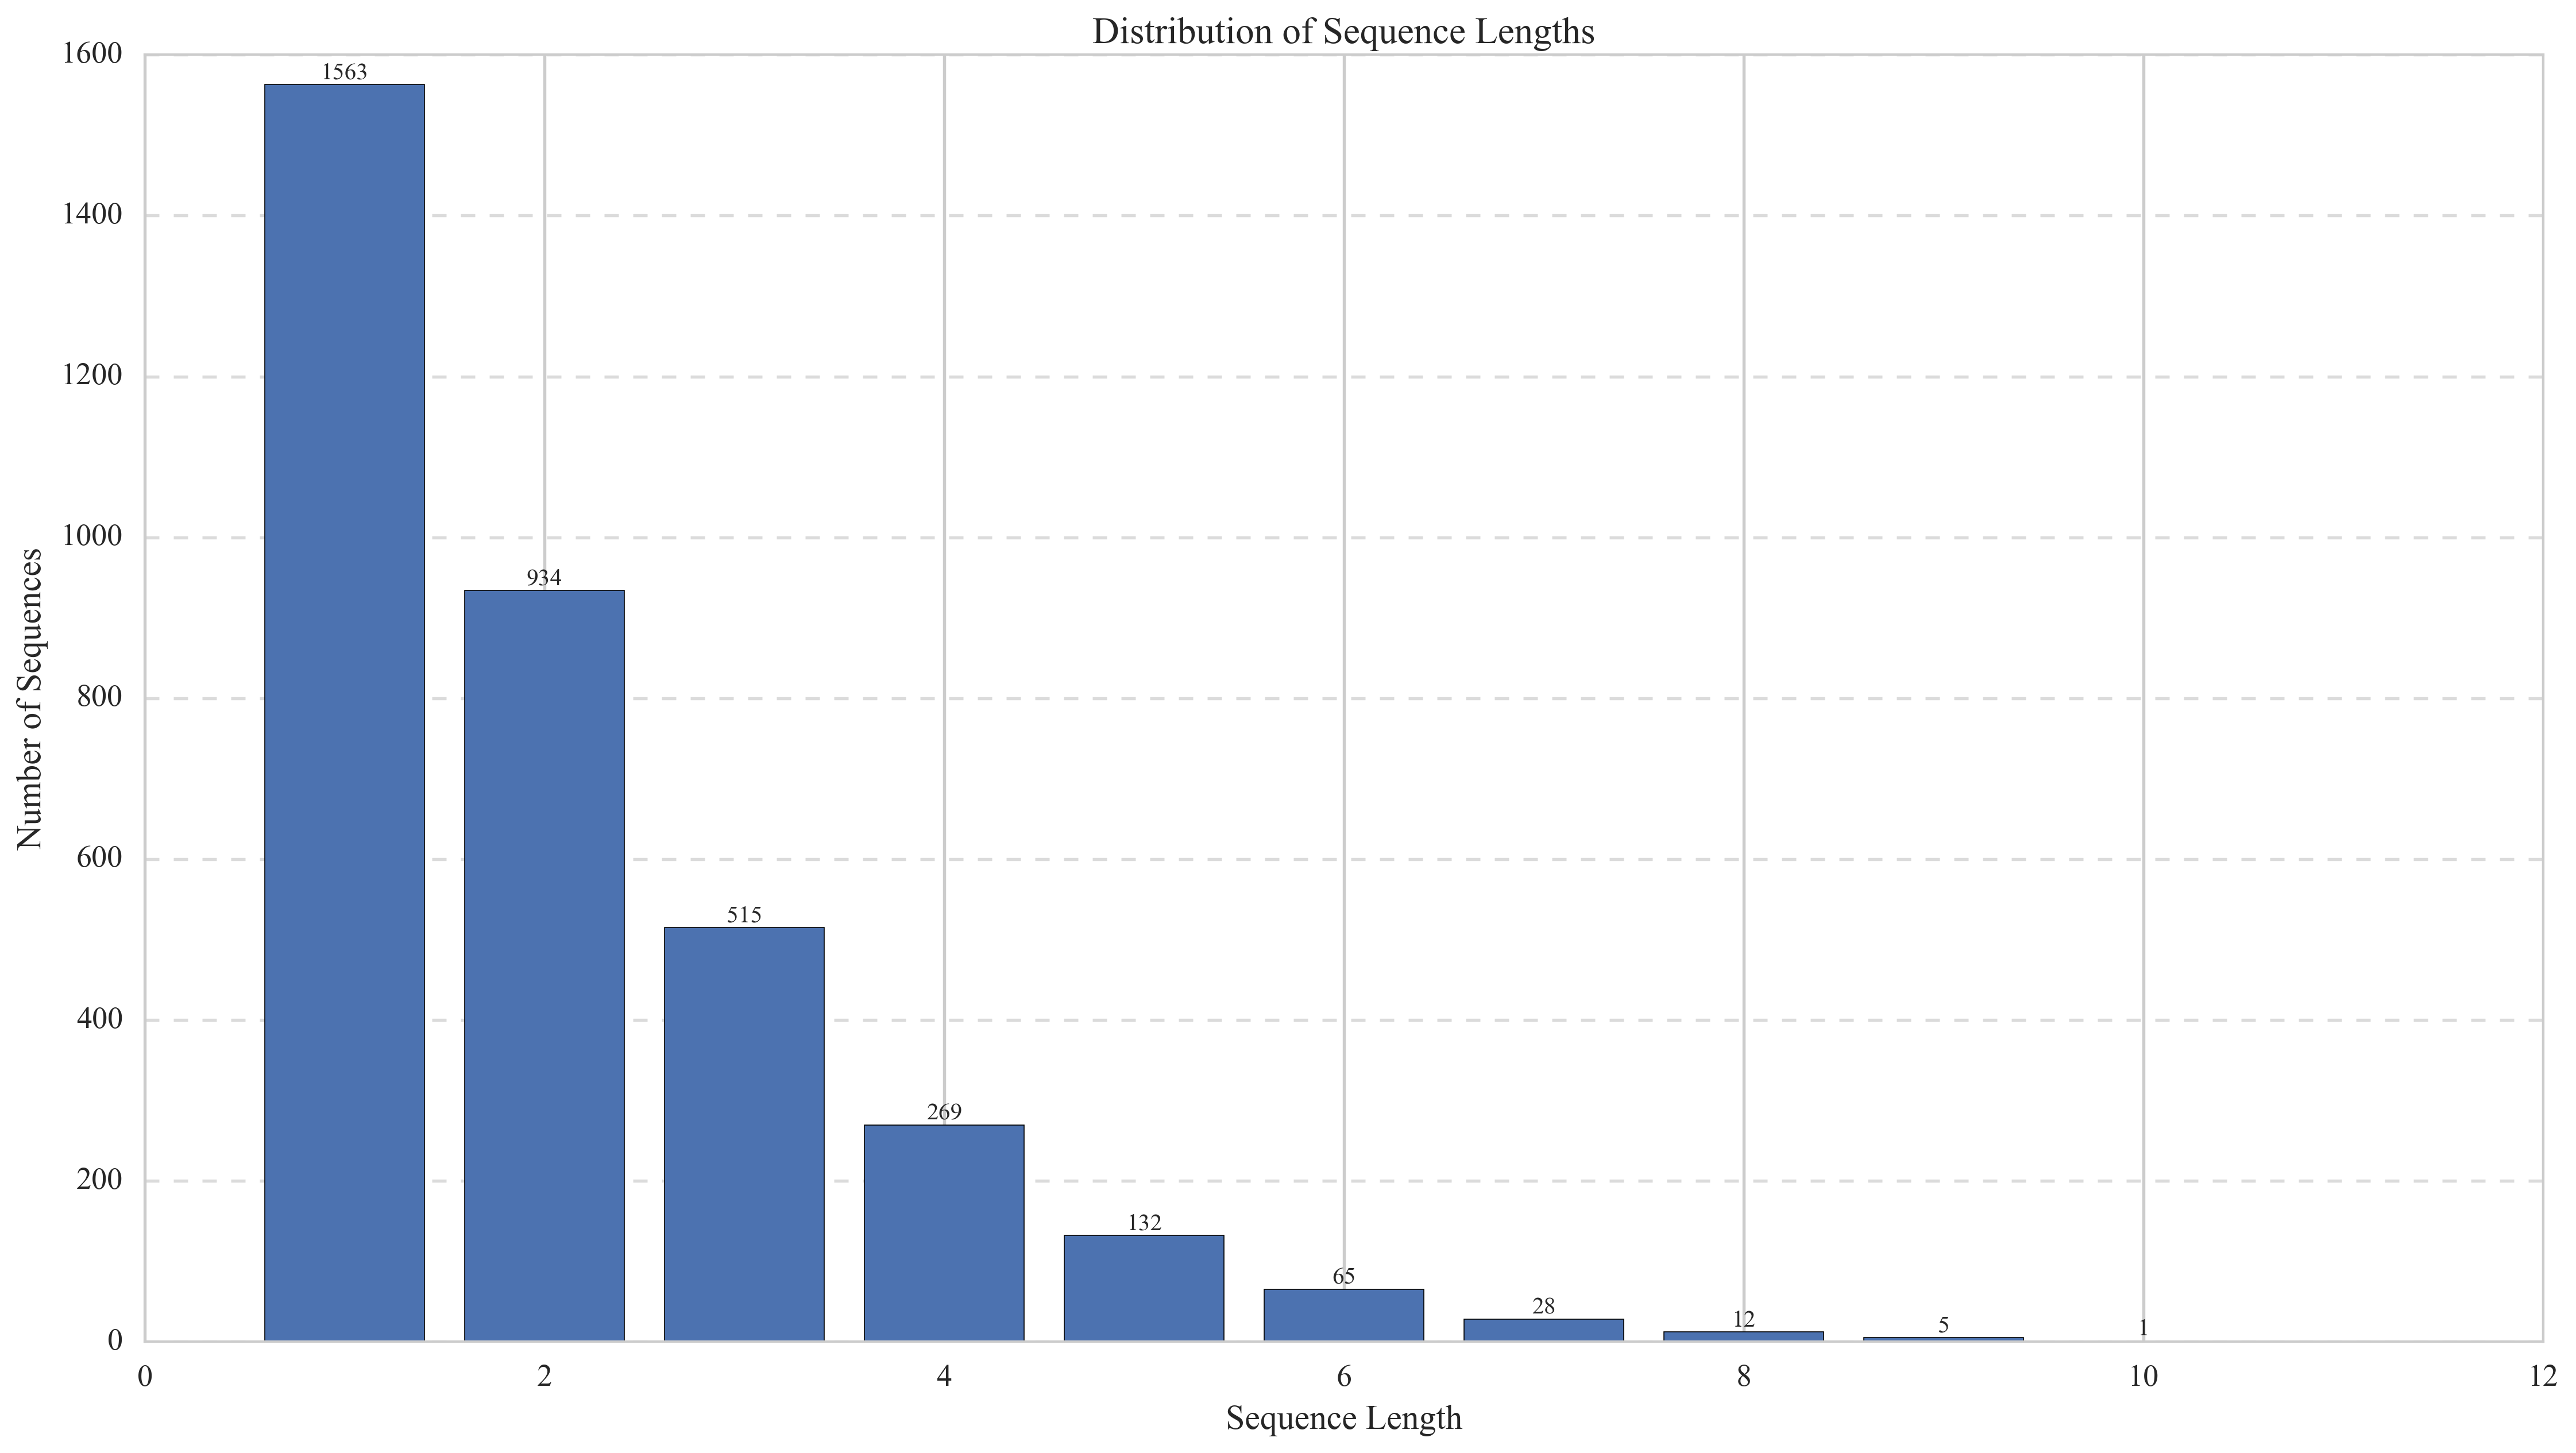

In [98]:
from collections import Counter

# Assuming seq_len_test is a list of sequence lengths
sequence_lengths = seq_len_test

# Count the occurrences of each sequence length
length_counts = Counter(sequence_lengths)

# Get the unique sequence lengths and their counts
unique_lengths = list(length_counts.keys())
counts = list(length_counts.values())

# Create the bar plot
plt.figure(figsize=(16, 9), dpi=300)
plt.bar(unique_lengths, counts)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequence Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the numbers on top of the bars
for i, count in enumerate(counts):
    plt.text(unique_lengths[i], count + 1, str(count), ha='center', va='bottom')

plt.show()


In [78]:
# import matplotlib.pyplot as plt

# def plot_sequence_lengths(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Create the bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(sequence_lengths)), sequence_lengths)
#     plt.xlabel('Sequence Index')
#     plt.ylabel('Sequence Length')
#     plt.title('Lengths of Sequences')
#     plt.show()

# # Plot for train sequences
# plot_sequence_lengths(train_sequences)

# # Plot for validation sequences
# plot_sequence_lengths(val_sequences)

# # Plot for test sequences
# plot_sequence_lengths(test_sequences)


In [79]:
# import plotly.graph_objects as go

# def plot_sequence_length_distribution(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Calculate the count of sequences for each length
#     sequence_length_counts = {length: sequence_lengths.count(length) for length in range(1, max(sequence_lengths) + 1)}

#     # Create the bar plot
#     fig = go.Figure(data=[go.Bar(x=list(sequence_length_counts.keys()), y=list(sequence_length_counts.values()))])
#     fig.update_layout(title='Distribution of Sequence Lengths',
#                       xaxis_title='Sequence Length',
#                       yaxis_title='Count',
#                       xaxis=dict(dtick=1),
#                       yaxis=dict(type='log', dtick=1))

#     fig.show()

# # Plot for train sequences
# plot_sequence_length_distribution(train_sequences)

# # Plot for validation sequences
# plot_sequence_length_distribution(val_sequences)

# # Plot for test sequences
# plot_sequence_length_distribution(test_sequences)


In [99]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, TimeDistributed, Flatten
from keras import backend as K

# Activate matplotlib interactive mode
plt.ion()


## Training Cox Model


In [100]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from itertools import product

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1


# Assuming 'cox_data' is your DataFrame
# Split your data into a training set and a test set
train_data, test_data = train_test_split(cox_data, test_size=0.2, random_state=42)  # Adjust test_size as needed

best_params = {'alpha': 0.01, 'n_baseline_knots': 2, 'l1_ratio': 0.0}
# After the loop, use the best hyperparameters to train the model
best_alpha = best_params['alpha']
best_n_baseline_knots = best_params['n_baseline_knots']
best_l1_ratio = best_params['l1_ratio']

# Initialize Cox proportional hazards model with the best hyperparameters
coxph_best = CoxPHFitter(alpha=0.01, n_baseline_knots=2)

# Fit the Cox model to the training data with the best hyperparameters
coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

predicted_median_survival_time = coxph_best.predict_expectation(test_data)



## Designing RNN Models

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Dense
import tensorflow as tf


def get_model(model_type='LSTM', units_1=64, units_2=32, activation='relu', num_dense_layers=2, dense_units=[16, 8], loss='mean_absolute_error', optimizer='adam', learning_rate=0.001):
    if model_type not in ['LSTM', 'BiLSTM', 'RNN', 'GRU']:
        raise ValueError("Invalid model_type. Choose from 'LSTM', 'BiLSTM', 'RNN', or 'GRU'.")

    rnn_layer_1 = None
    rnn_layer_2 = None

    if model_type == 'LSTM':
        rnn_layer_1 = LSTM(units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = LSTM(units_2)
    elif model_type == 'BiLSTM':
        rnn_layer_1 = Bidirectional(LSTM(units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        rnn_layer_2 = Bidirectional(LSTM(units_2))
    elif model_type == 'RNN':
        rnn_layer_1 = SimpleRNN(units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = SimpleRNN(units_2)
    else:
        raise ValueError("Invalid model_type. Choose from 'LSTM', 'BiLSTM', 'RNN', or 'GRU'.")

    model = Sequential()
    model.add(rnn_layer_1)
    model.add(rnn_layer_2)

    for i in dense_units:
        model.add(Dense(i, activation=activation))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    return model


## Training RNN Models

In [102]:
from IPython.display import clear_output

def train_model(model, train_X, train_y, val_X, val_y, patience=5, max_epochs=50):

    # Initialize lists for storing MAE values and attention weights
    train_mae = []
    val_mae = []
    train_seq_lengths = [len(seq) for seq in train_X]

    best_val_mae = float('inf')
    best_weights = None
    epochs_without_improvement = 0

    for epoch in range(1, max_epochs + 1):  # You can adjust the maximum number of epochs here
        history = model.fit(train_X, train_y, epochs=1, batch_size=32, validation_data=(val_X, val_y),
                            sample_weight=np.array(train_seq_lengths), verbose=0)

        # Update lists with MAE values
        train_mae.append(history.history['mean_absolute_error'][0])
        val_mae.append(history.history['val_mean_absolute_error'][0])

        # Check for early stopping
        if val_mae[-1] < best_val_mae:
            best_val_mae = val_mae[-1]
            best_weights = model.get_weights()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch} epochs.")
                break
        
        print(f"Epoch {epoch} - train MAE: {train_mae[-1]}, val MAE: {val_mae[-1]}")

    # Reset model to best weights
    model.set_weights(best_weights)

    return model


In [103]:
models = {
    "LSTM": None,
    "BiLSTM": None,
    "RNN": None,
}

## Hyperparameter Tuning

In [104]:
import time
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

hyperparameters = {
    'units_1': [128, 64],
    'units_2': [64, 32],
    'dense_units': [[16, 8], [32, 16]],
    'learning_rate': [0.001],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu']
}


# Initialize a dictionary to store the best parameters for LSTM and BiLSTM
best_params = {'LSTM': {}, 'BiLSTM': {}, 'RNN': {}}
search_results = {'LSTM': {}, 'BiLSTM': {}, 'RNN': {}}

# Define a function to perform grid search
def grid_search(model_type, hyperparameters):
    best_val_mae = float('inf')
    best_params[model_type] = {}

    records = []

    for config in ParameterGrid(hyperparameters):
        print(f"Evaluating Config: {config}")

        # Create and compile the model
        model = get_model(model_type=model_type, **config)
       
        
        
        # Measure time taken
        start_time = time.time()

        # Train the model
        trained_model = train_model(model, X_train, y_train, X_val, y_val)

        # Calculate time taken
        end_time = time.time()
        training_time = end_time - start_time

        # Get number of epochs
        num_epochs = len(trained_model.history.history['loss'])

        # Evaluate on validation set
        val_mae = trained_model.evaluate(X_val, y_val, verbose=0)[1]

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params[model_type] = config

        # Store results
        records.append({
            'Config': config,
            'MAE': val_mae,
            'Training Time (s)': training_time,
            'Epochs': num_epochs
        })


    
    return best_params[model_type], records


In [105]:
from sklearn.model_selection import ParameterGrid

# Perform grid search for LSTM
#best_params['LSTM'], search_results['LSTM'] = grid_search('LSTM', hyperparameters)


In [106]:
best_params['LSTM']

{}

In [107]:

# Perform grid search for BiLSTM
#best_params['BiLSTM'], search_results['BiLSTM'] = grid_search('BiLSTM', hyperparameters)


In [108]:
best_params['BiLSTM']

{}

In [109]:
#best_params['RNN'], search_results['RNN'] = grid_search('RNN', hyperparameters)


In [110]:
best_params['RNN']

{}

In [111]:
import pandas as pd

# Create a DataFrame to display grid search results
results_df = pd.DataFrame(best_params)

# Display the table
print(results_df)


Empty DataFrame
Columns: [LSTM, BiLSTM, RNN]
Index: []


In [93]:
# from tensorflow.keras.utils import plot_model

# plot_model(models["RNN"], to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image, display

# # Assuming 'model_plot.png' is the file name
# display(Image(filename='model_plot.png'))

In [112]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    # Use the model to make predictions
    y_pred = model.predict(X_test)

    # Flatten the predictions to 1D arrays
    y_test_flattened = y_test.flatten()
    y_pred_flattened = y_pred.flatten()

    # Calculate evaluation metrics
    mae_val = mean_absolute_error(y_test_flattened, y_pred_flattened)
    mse_val = mean_squared_error(y_test_flattened, y_pred_flattened)
    r2_val = r2_score(y_test_flattened, y_pred_flattened)
    c_index = concordance_index(y_test_flattened, y_pred_flattened)

    return mae_val, mse_val, r2_val, c_index


In [113]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_cox_model(test_data, predicted_median_survival_time):
    # Extract the observed event times and event indicators from the test data
    observed_times = test_data['DaysOpen']
    event_observed = test_data['Event']

    # Filter out infinite values from observed_times and predicted_median_survival_time
    finite_mask = np.isfinite(observed_times) & np.isfinite(predicted_median_survival_time)
    observed_times_finite = observed_times[finite_mask]
    predicted_median_survival_time_finite = predicted_median_survival_time[finite_mask]

    # Calculate the C-index
    c_index = concordance_index(observed_times_finite, predicted_median_survival_time_finite, event_observed[finite_mask])

    # Calculate Mean Absolute Error (MAE) for Survival, ignoring infinite values
    mae_survival = mean_absolute_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate Mean Squared Error (MSE) for Survival, ignoring infinite values
    mse_survival = mean_squared_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate R2 score for Survival, ignoring infinite values
    r2_survival = r2_score(observed_times_finite, predicted_median_survival_time_finite)

    return c_index, mae_survival, mse_survival, r2_survival



In [115]:
config = {'LSTM': {'activation': 'relu',
                   'dense_units': [32, 16],
                   'learning_rate': 0.001,
                   'optimizer': 'sgd',
                   'units_1': 64,
                   'units_2': 32},
          'BiLSTM': {'activation': 'relu',
                     'dense_units': [16, 8],
                     'learning_rate': 0.001,
                     'optimizer': 'adam',
                     'units_1': 64,
                     'units_2': 64},
          'RNN': {'activation': 'relu',
                  'dense_units': [16, 8],
                  'learning_rate': 0.001,
                  'optimizer': 'rmsprop',
                  'units_1': 64,
                  'units_2': 32}}

## Evaluate Sequences Function

In [116]:
def evaluate_on_actual_sequence_length(model, X, y, seq_lengths, max_sequence_length=10):
    mae_values = []

    for seq_length in range(1, max_sequence_length + 1):
        # Filter sequences with the specified length
        indices = [i for i, seq_len in enumerate(seq_lengths) if seq_len == seq_length]
        if len(indices) > 0:
            X_subset = X[indices]
            y_subset = y[indices]

            # Calculate MAE
            mae = model.evaluate(X_subset, y_subset, verbose=0)[1]
            mae_values.append(mae)
        else:
            mae_values.append(0)

    return np.array(mae_values)

In [117]:
X_test.shape

(3524, 10, 22)

## Training Process

In [137]:
all_models = ['Cox', 'LSTM', 'RNN', 'BiLSTM']
rnn_models = ['RNN', 'LSTM',  'BiLSTM']
metrics = ['C-Index', 'MAE', 'MSE', 'R2']

In [119]:
def has_disorder(sequence):
    last_record = sequence[-1]
    for disorder in disorders:
        disorder_index = sequence_features.index(disorder)
        if last_record[disorder_index] == 1:
            return True
    return False

In [120]:
def evaluate_on_disorder_data(model, X, y):
    indices = [i for i, seq in enumerate(X) if has_disorder(seq)]
    X_subset = X[indices]
    y_subset = y[indices]

    # Calculate MAE
    mae = model.evaluate(X_subset, y_subset, verbose=0)[1]

    return mae


def evaluate_on_healthy_data(model, X, y):
    indices = [i for i, seq in enumerate(X) if not has_disorder(seq)]
    X_subset = X[indices]
    y_subset = y[indices]

    # Calculate MAE
    mae = model.evaluate(X_subset, y_subset, verbose=0)[1]

    return mae

In [121]:

# Define the number of training runs
num_training_runs = 10
max_epochs = 50
max_sequence_length = 10

# Initialize a dictionary to store MAE values for each model
sequence_evaluation_results = {model_type: np.zeros(max_sequence_length) for model_type in rnn_models}

# Initialize a dictionary to store MAE values for diseased and healthy cows
health_evaluation_results = {model_type:{"diseased": 0, "healthy": 0} for model_type in rnn_models}


# Create a dictionary to store evaluation results
evaluation_results = {model_type: {metric: [] for metric in metrics} for model_type in all_models}

# Perform multiple training runs

for run in range(num_training_runs):
    print(f"Training Run {run + 1}")

    # Train RNN models
    for model_type in rnn_models:
        print(f"Training {model_type}")
        tf.random.set_seed(run)
        X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test = create_data(
            filled_data, seed=run, max_sequence_length=max_sequence_length)

        # Create and compile the model
        models[model_type] = get_model(
            model_type=model_type, **config[model_type])
        models[model_type] = train_model(
            models[model_type], X_train, y_train, X_val, y_val, max_epochs=max_epochs)

        # Evaluate the model
        mae_val, mse_val, r2_val, c_index = evaluate_model(
            models[model_type], X_test, y_test)
        evaluation_results[model_type].get('MAE').append(mae_val)
        evaluation_results[model_type].get('MSE').append(mse_val)
        evaluation_results[model_type].get('R2').append(r2_val)
        evaluation_results[model_type].get('C-Index').append(c_index)
        sequence_mae_values = evaluate_on_actual_sequence_length(models[model_type], X_test, y_test, seq_len_test, max_sequence_length=max_sequence_length)
        sequence_evaluation_results[model_type] = sequence_evaluation_results[model_type] + (sequence_mae_values / num_training_runs)
        health_evaluation_results[model_type]['healthy'] = health_evaluation_results[model_type]['healthy'] +  (evaluate_on_healthy_data(models[model_type], X_test, y_test) / num_training_runs)
        health_evaluation_results[model_type]['diseased'] = health_evaluation_results[model_type]['diseased'] +  (evaluate_on_disorder_data(models[model_type], X_test, y_test) / num_training_runs)

    # Train Cox model
    train_data, test_data = train_test_split(
        cox_data, test_size=0.2, random_state=run)  # Adjust test_size as needed
    coxph_best = CoxPHFitter(alpha=0.01, n_baseline_knots=2)
    coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

    # Evaluate the Cox model
    cox_evaluation_results = evaluate_cox_model(
        test_data, coxph_best.predict_expectation(test_data))
    for metric, value in zip(['C-Index', 'MAE', 'MSE', 'R2'], cox_evaluation_results):
        evaluation_results['Cox'][metric].append(value)

Training Run 1
Training LSTM
Epoch 1 - train MAE: 98.67124938964844, val MAE: 73.2264404296875
Epoch 2 - train MAE: 68.27550506591797, val MAE: 73.22992706298828
Epoch 3 - train MAE: 68.27735137939453, val MAE: 73.22892761230469
Epoch 4 - train MAE: 68.27942657470703, val MAE: 73.22808837890625
Epoch 5 - train MAE: 63.011131286621094, val MAE: 33.50270462036133
Epoch 6 - train MAE: 14.641685485839844, val MAE: 7.387880325317383
Epoch 7 - train MAE: 5.359837532043457, val MAE: 4.348460674285889
Epoch 8 - train MAE: 3.4219753742218018, val MAE: 3.5959372520446777
Epoch 9 - train MAE: 2.891786813735962, val MAE: 2.628643274307251
Epoch 10 - train MAE: 2.34853196144104, val MAE: 1.9540892839431763
Epoch 11 - train MAE: 1.9736016988754272, val MAE: 1.8100255727767944
Epoch 12 - train MAE: 1.7877401113510132, val MAE: 3.0340685844421387
Epoch 13 - train MAE: 1.641977310180664, val MAE: 1.702654480934143
Epoch 14 - train MAE: 1.4954060316085815, val MAE: 1.398667335510254
Epoch 15 - train MAE

In [141]:
import os

# Define a directory to save the models
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

for model_type in rnn_models:
    model_filename = f'{model_type.lower()}_model.h5'
    model_path = os.path.join(save_dir, model_filename)
    models[model_type].save(model_path)
    print(f"{model_type} model saved at {model_path}")

C:\Users\gheys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



RNN model saved at saved_models\rnn_model.h5
LSTM model saved at saved_models\lstm_model.h5
BiLSTM model saved at saved_models\bilstm_model.h5


In [122]:
health_evaluation_results

{'LSTM': {'diseased': 0.9366440653800964, 'healthy': 0.6948278605937958},
 'RNN': {'diseased': 1.5429417133331298, 'healthy': 1.1090551793575287},
 'BiLSTM': {'diseased': 0.9481430232524872, 'healthy': 0.6596402317285537}}

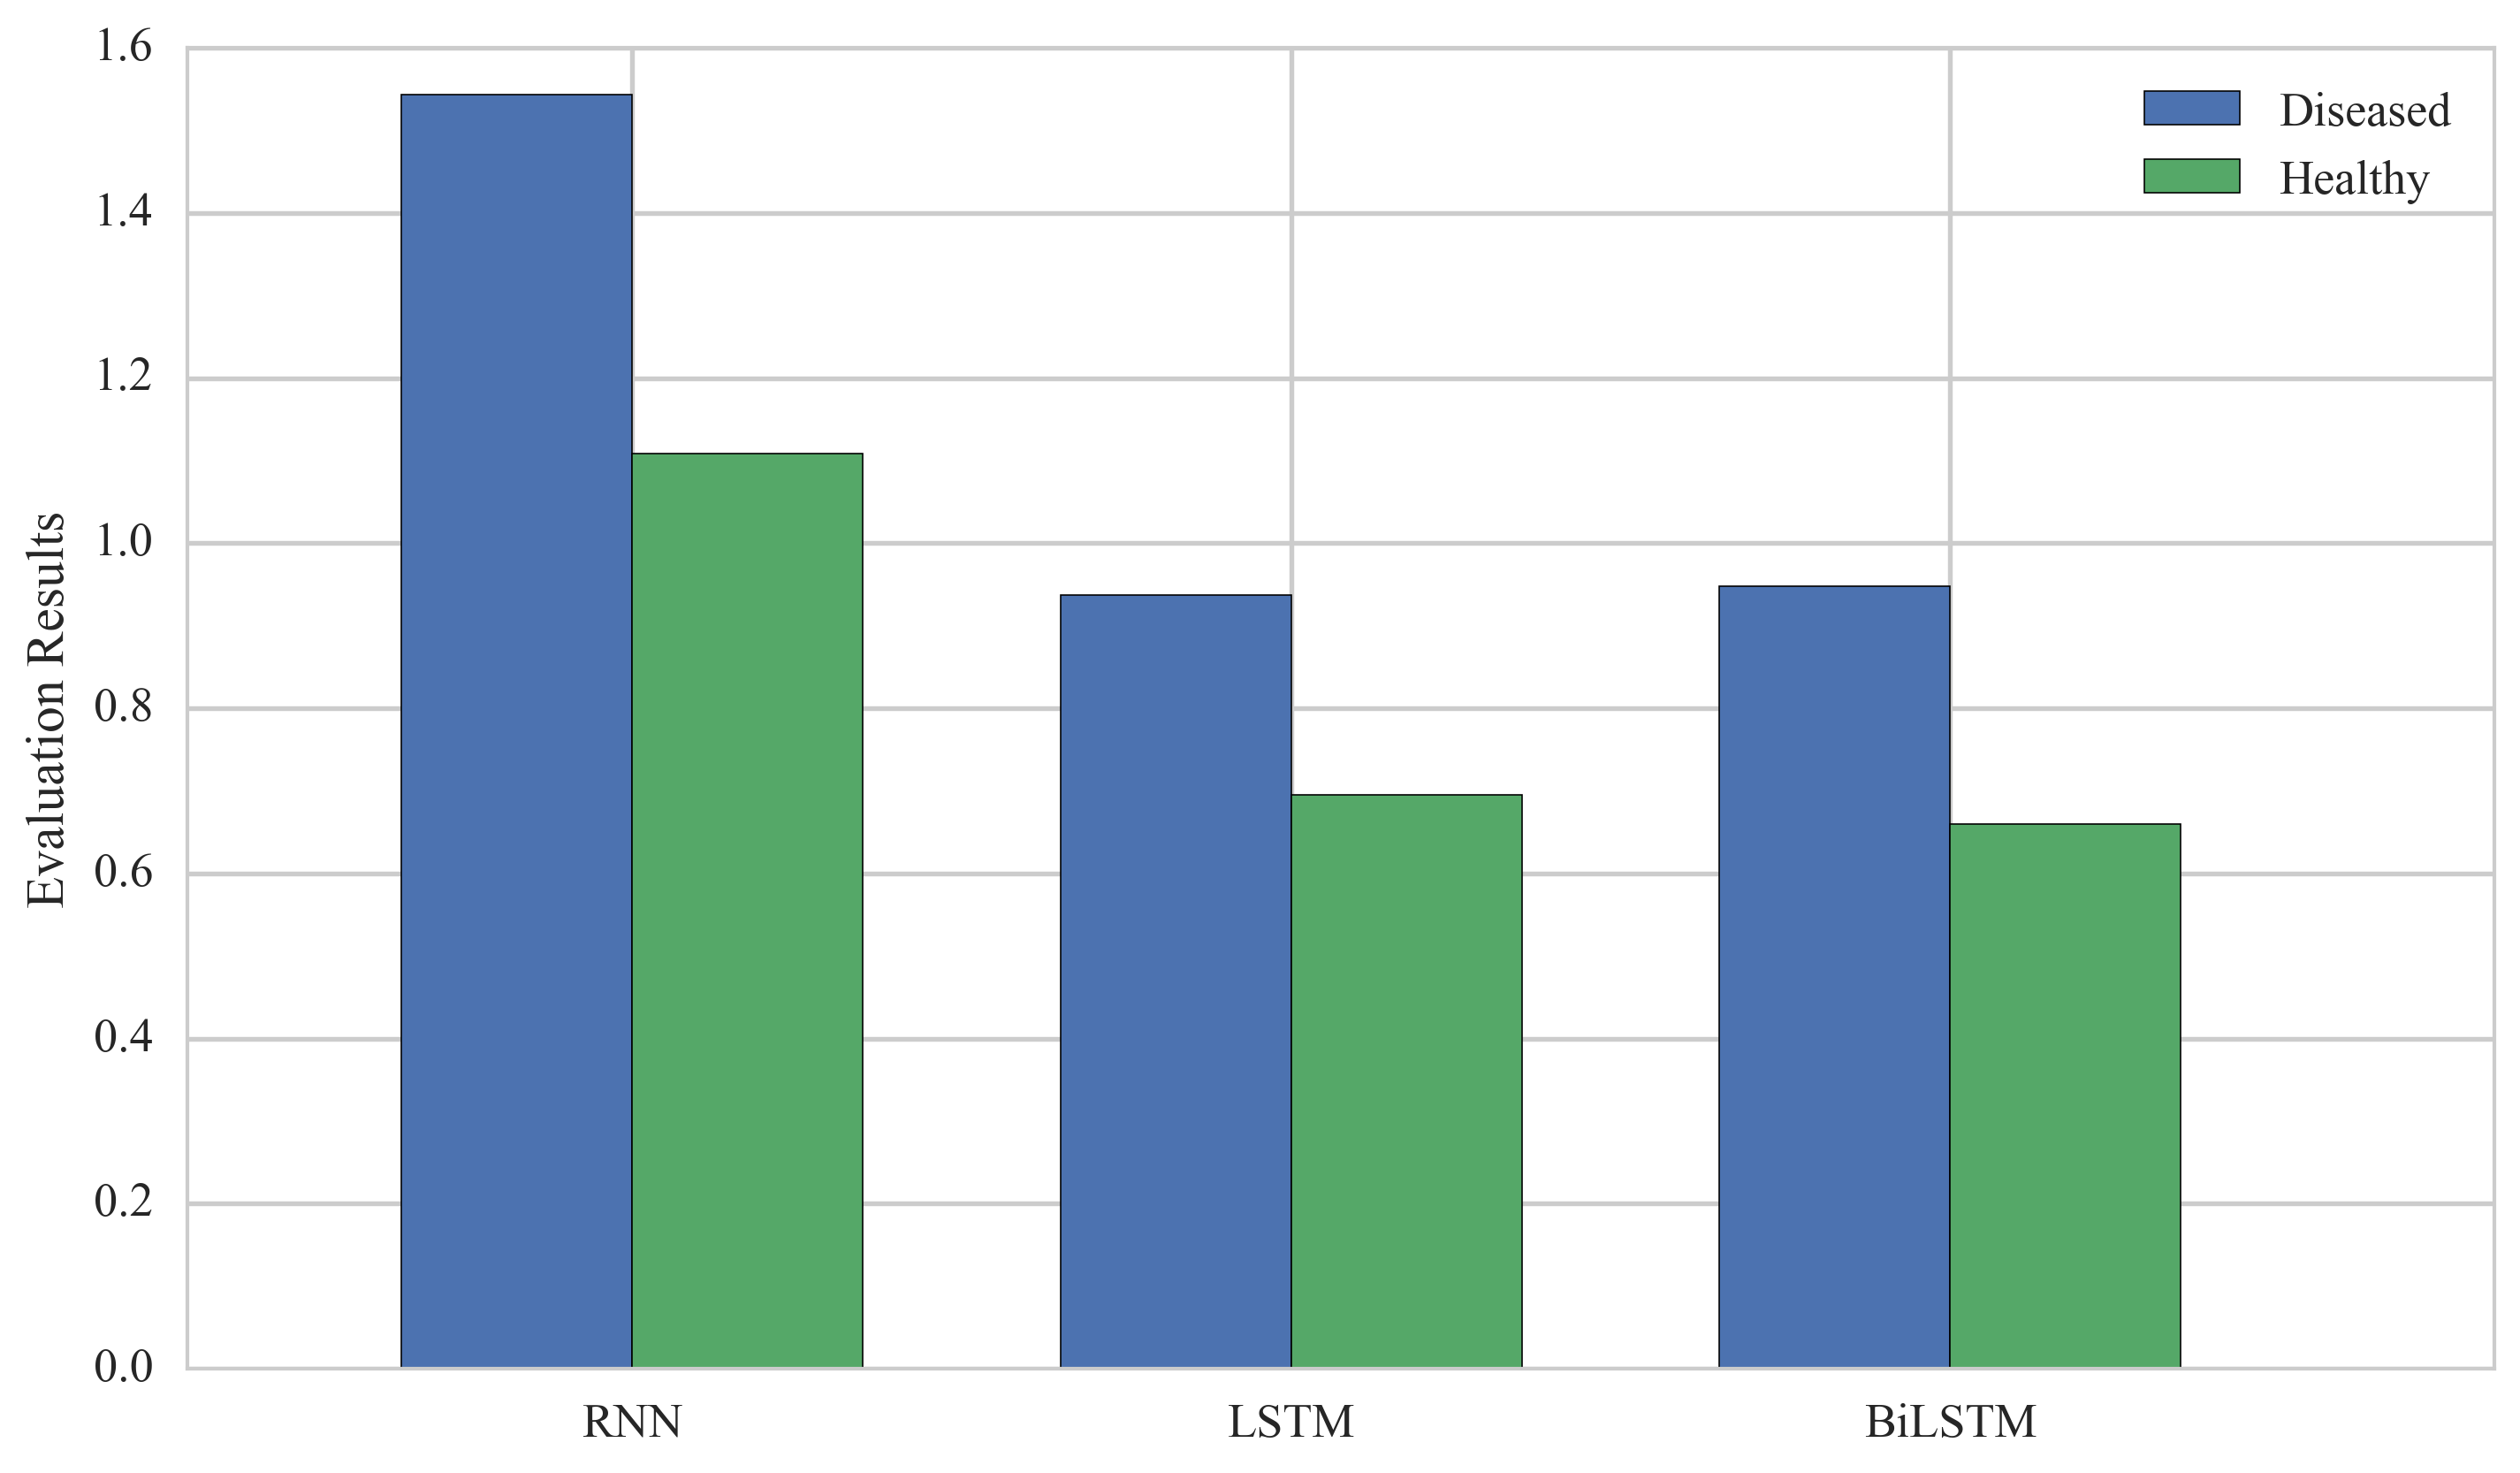

In [145]:
import seaborn as sns

model_types = ['RNN', 'LSTM', 'BiLSTM']
diseased_values = [health_evaluation_results[model_type]['diseased'] for model_type in model_types]
healthy_values = [health_evaluation_results[model_type]['healthy'] for model_type in model_types]

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

x = range(len(model_types))
width = 0.35

rects1 = ax.bar(x, diseased_values, width, label='Diseased')
rects2 = ax.bar([i + width for i in x], healthy_values, width, label='Healthy')

ax.set_ylabel('Evaluation Results')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(model_types)
ax.legend()

# Change the file extension to save as SVG
plt.savefig('health_results.svg')
plt.show()


In [128]:
sequence_evaluation_results

{'LSTM': array([0.60769192, 0.78606651, 0.96610155, 1.06531603, 1.1065281 ,
        1.12870448, 1.06242512, 0.93352968, 0.77425846, 0.32583199]),
 'RNN': array([0.91259034, 1.28483957, 1.61859161, 1.75053364, 1.94093924,
        2.12884173, 2.08765562, 2.29228075, 2.61759175, 0.60791359]),
 'BiLSTM': array([0.6206531 , 0.81512833, 0.8671598 , 0.88437299, 0.86746165,
        0.90367335, 1.09968113, 1.32699895, 3.19901489, 5.12424622])}

In [139]:
from tensorflow.keras.utils import plot_model

for model_type in ['LSTM', 'BiLSTM', 'RNN']:
    plot_model(
        models[model_type],
        to_file=f'{model_type.lower()}-architecture.png',
        show_shapes=True,
        show_layer_names=False,
        dpi=1200  # Adjust this value to increase the image size
    )


In [130]:
def average_model_values(model_dict):
    averaged_dict = {}
    for model, metrics in model_dict.items():
        averaged_metrics = {}
        for metric, values in metrics.items():
            averaged_metrics[metric] = np.mean(values)
        averaged_dict[model] = averaged_metrics
    return averaged_dict

In [131]:
results_df = pd.DataFrame(average_model_values(evaluation_results))
results_df

,Cox,LSTM,RNN,BiLSTM
C-Index,0.787606,0.998243,0.995471,0.998368
MAE,69.603856,0.770288,1.244871,0.748700
MSE,7970.979001,1.375658,3.248554,1.586258
R2,0.106834,0.999864,0.999674,0.999839


In [132]:


# Transpose the DataFrame for better representation
average_results_df = results_df

# Save the table as a CSV file
average_results_df.to_csv('average_results-minmax.csv')

# Display the table
print(average_results_df)


                 Cox      LSTM       RNN    BiLSTM
C-Index     0.787606  0.998243  0.995471  0.998368
MAE        69.603856  0.770288  1.244871  0.748700
MSE      7970.979001  1.375658  3.248554  1.586258
R2          0.106834  0.999864  0.999674  0.999839


In [133]:
import pandas as pd

def generate_line_plot_data(evaluation_results, model_names, metrics):
    line_plot_data = {}

    for model_type in model_names:
        model_data = {}
        for metric in metrics:
            metric_data = [evaluation_results[model_type][metric][run] for run in range(num_training_runs)]
            model_data[metric] = metric_data
        line_plot_data[model_type] = model_data

    return line_plot_data

# Usage:
line_plot_data = generate_line_plot_data(evaluation_results, rnn_models , metrics)


In [134]:
line_plot_data

{'LSTM': {'C-Index': [0.9986477379171077,
   0.9988777615101574,
   0.9990379453292653,
   0.9980221857723067,
   0.999173582800767,
   0.9981346664696552,
   0.9974821092381276,
   0.9992251029018828,
   0.9953572362382535,
   0.9984753816358877],
  'MAE': [0.6451538825134389,
   0.5942618665874208,
   0.5756076404244087,
   0.8524185860043668,
   0.6085421662429206,
   0.6803534545234889,
   0.8812658044729773,
   0.4708256933234215,
   1.683002536123042,
   0.7114451096256394],
  'MSE': [0.9340482524968111,
   0.8374544427167144,
   0.7096862681112605,
   1.4731154213284978,
   0.7296635280281221,
   0.9351547655209861,
   1.8447190630234542,
   0.4819239178901346,
   4.797801529631519,
   1.013011313918008],
  'R2': [0.9999154552115371,
   0.9999139376121704,
   0.9999268809599772,
   0.9998522305653762,
   0.999915913207363,
   0.9998983319570771,
   0.9998166287508213,
   0.9999481695673686,
   0.9995401804208417,
   0.9999088880980773]},
 'RNN': {'C-Index': [0.9937076100223431,


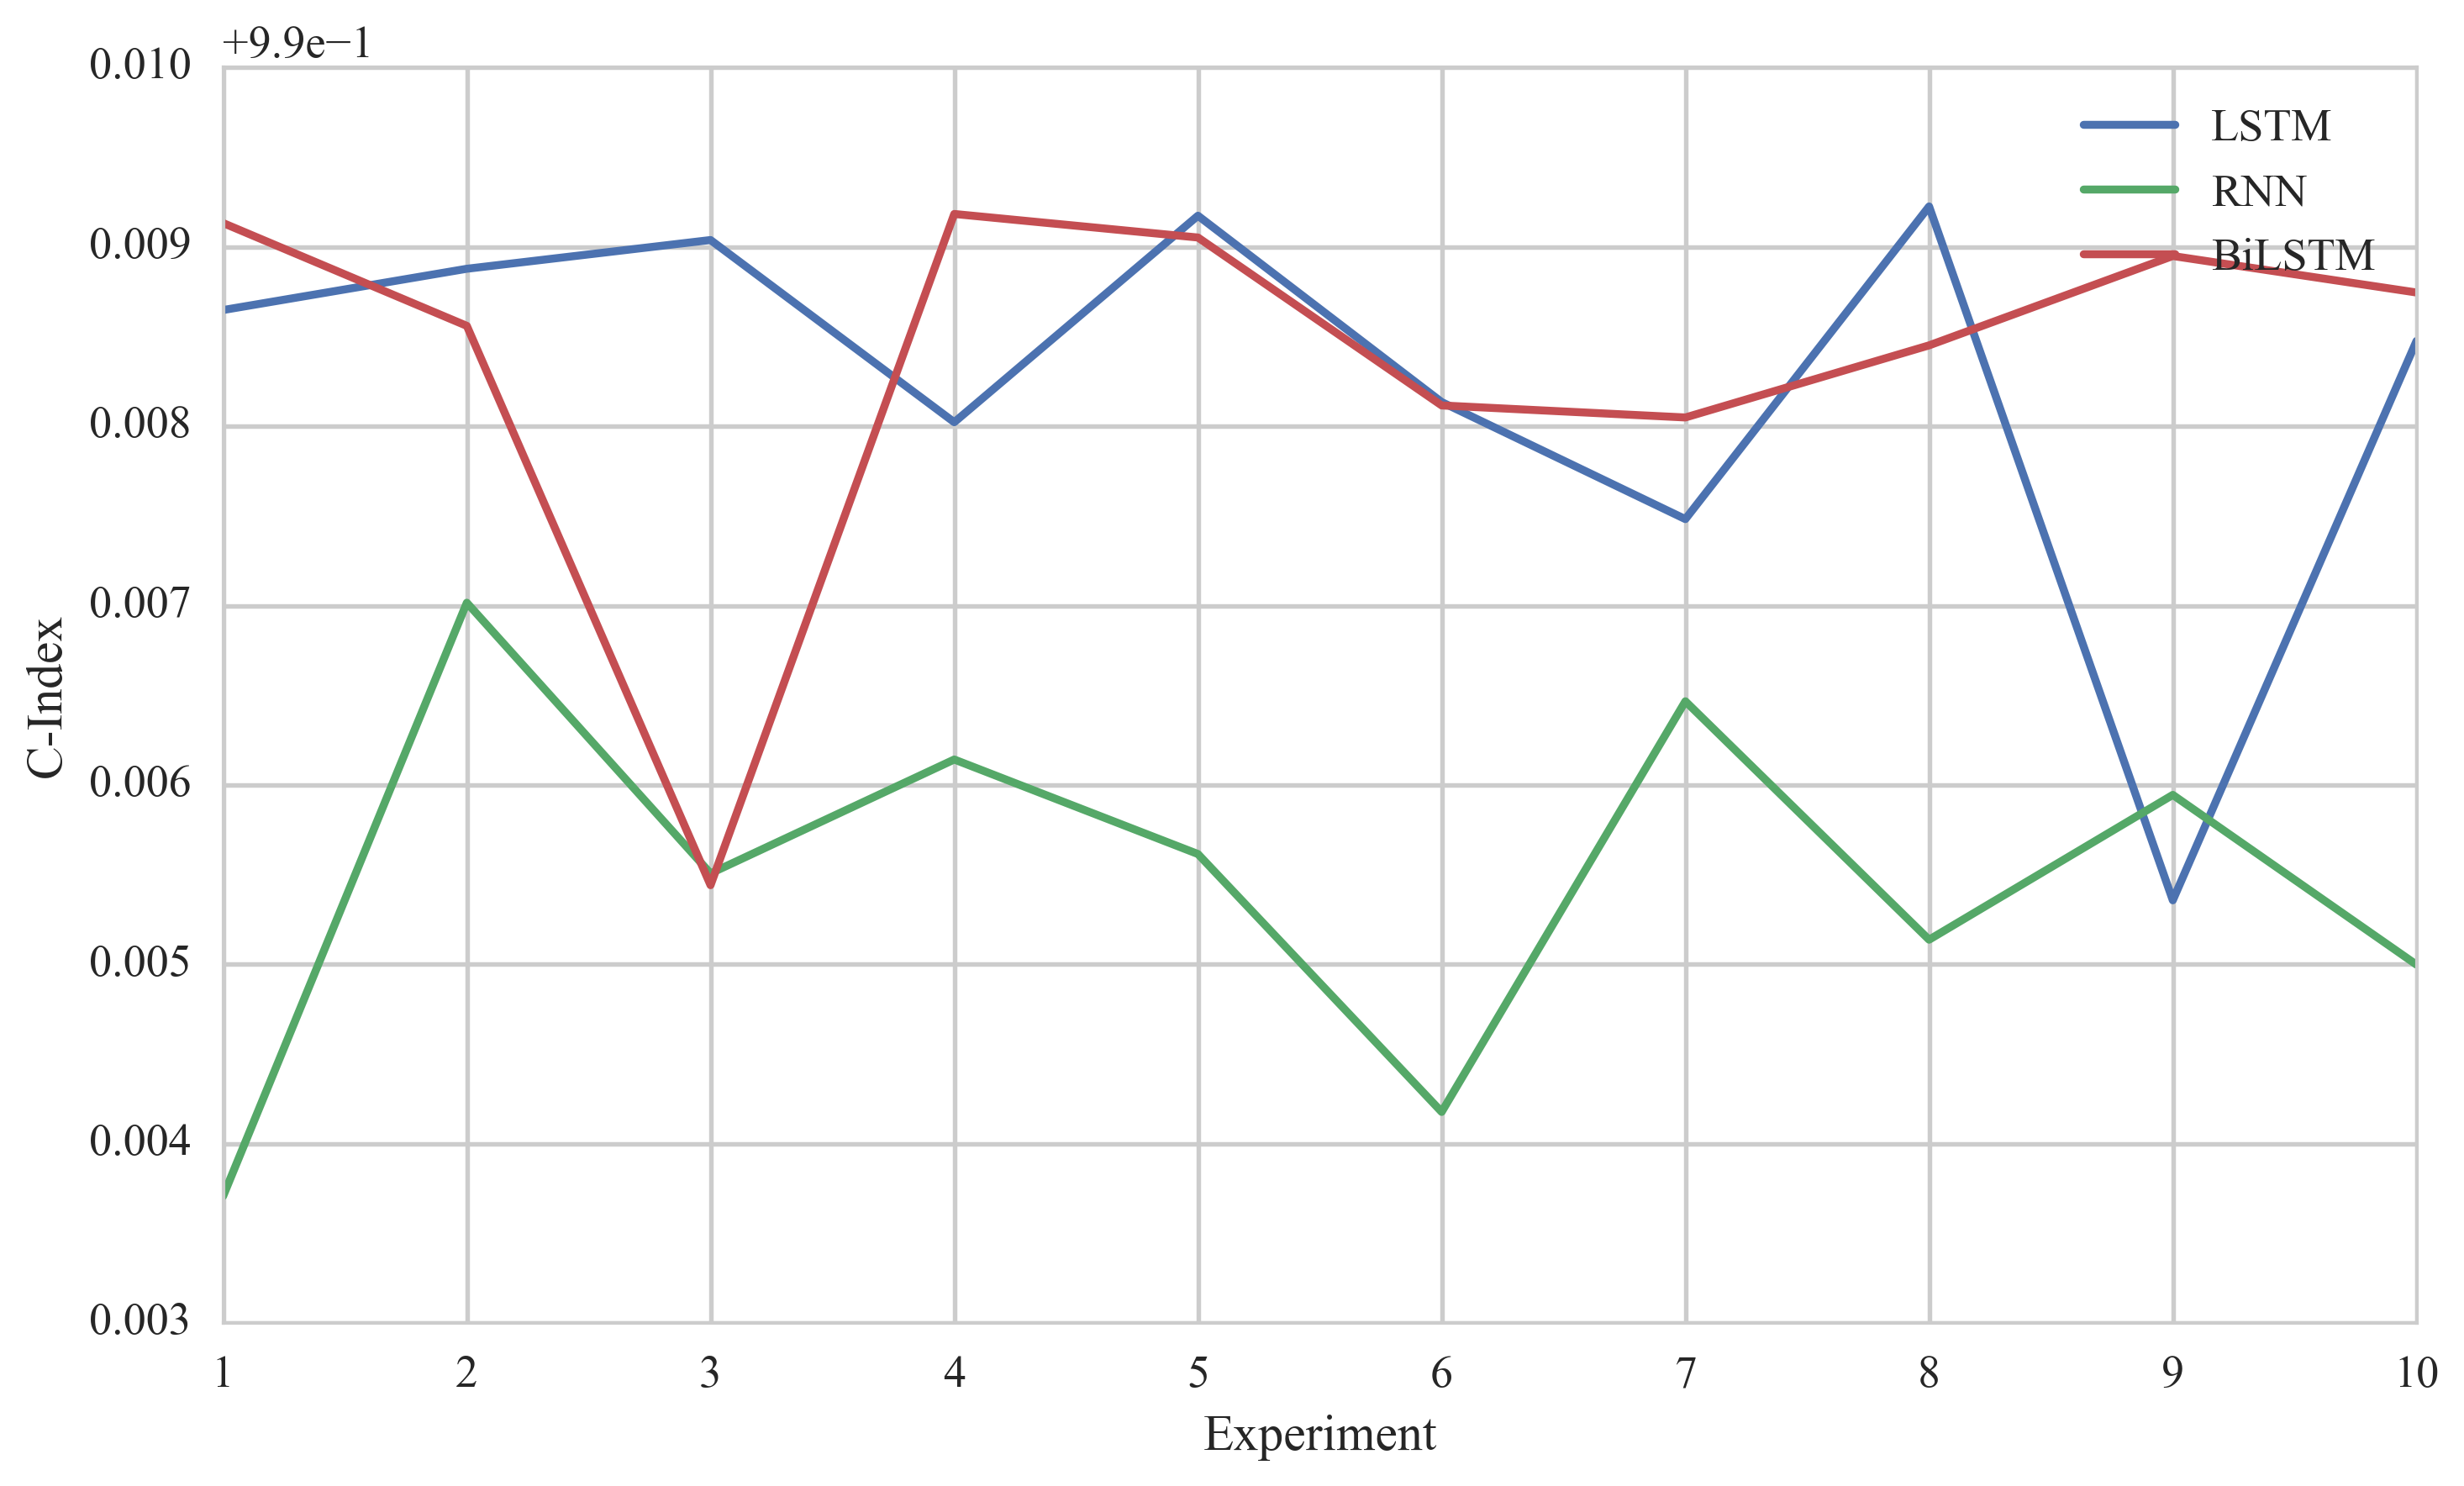

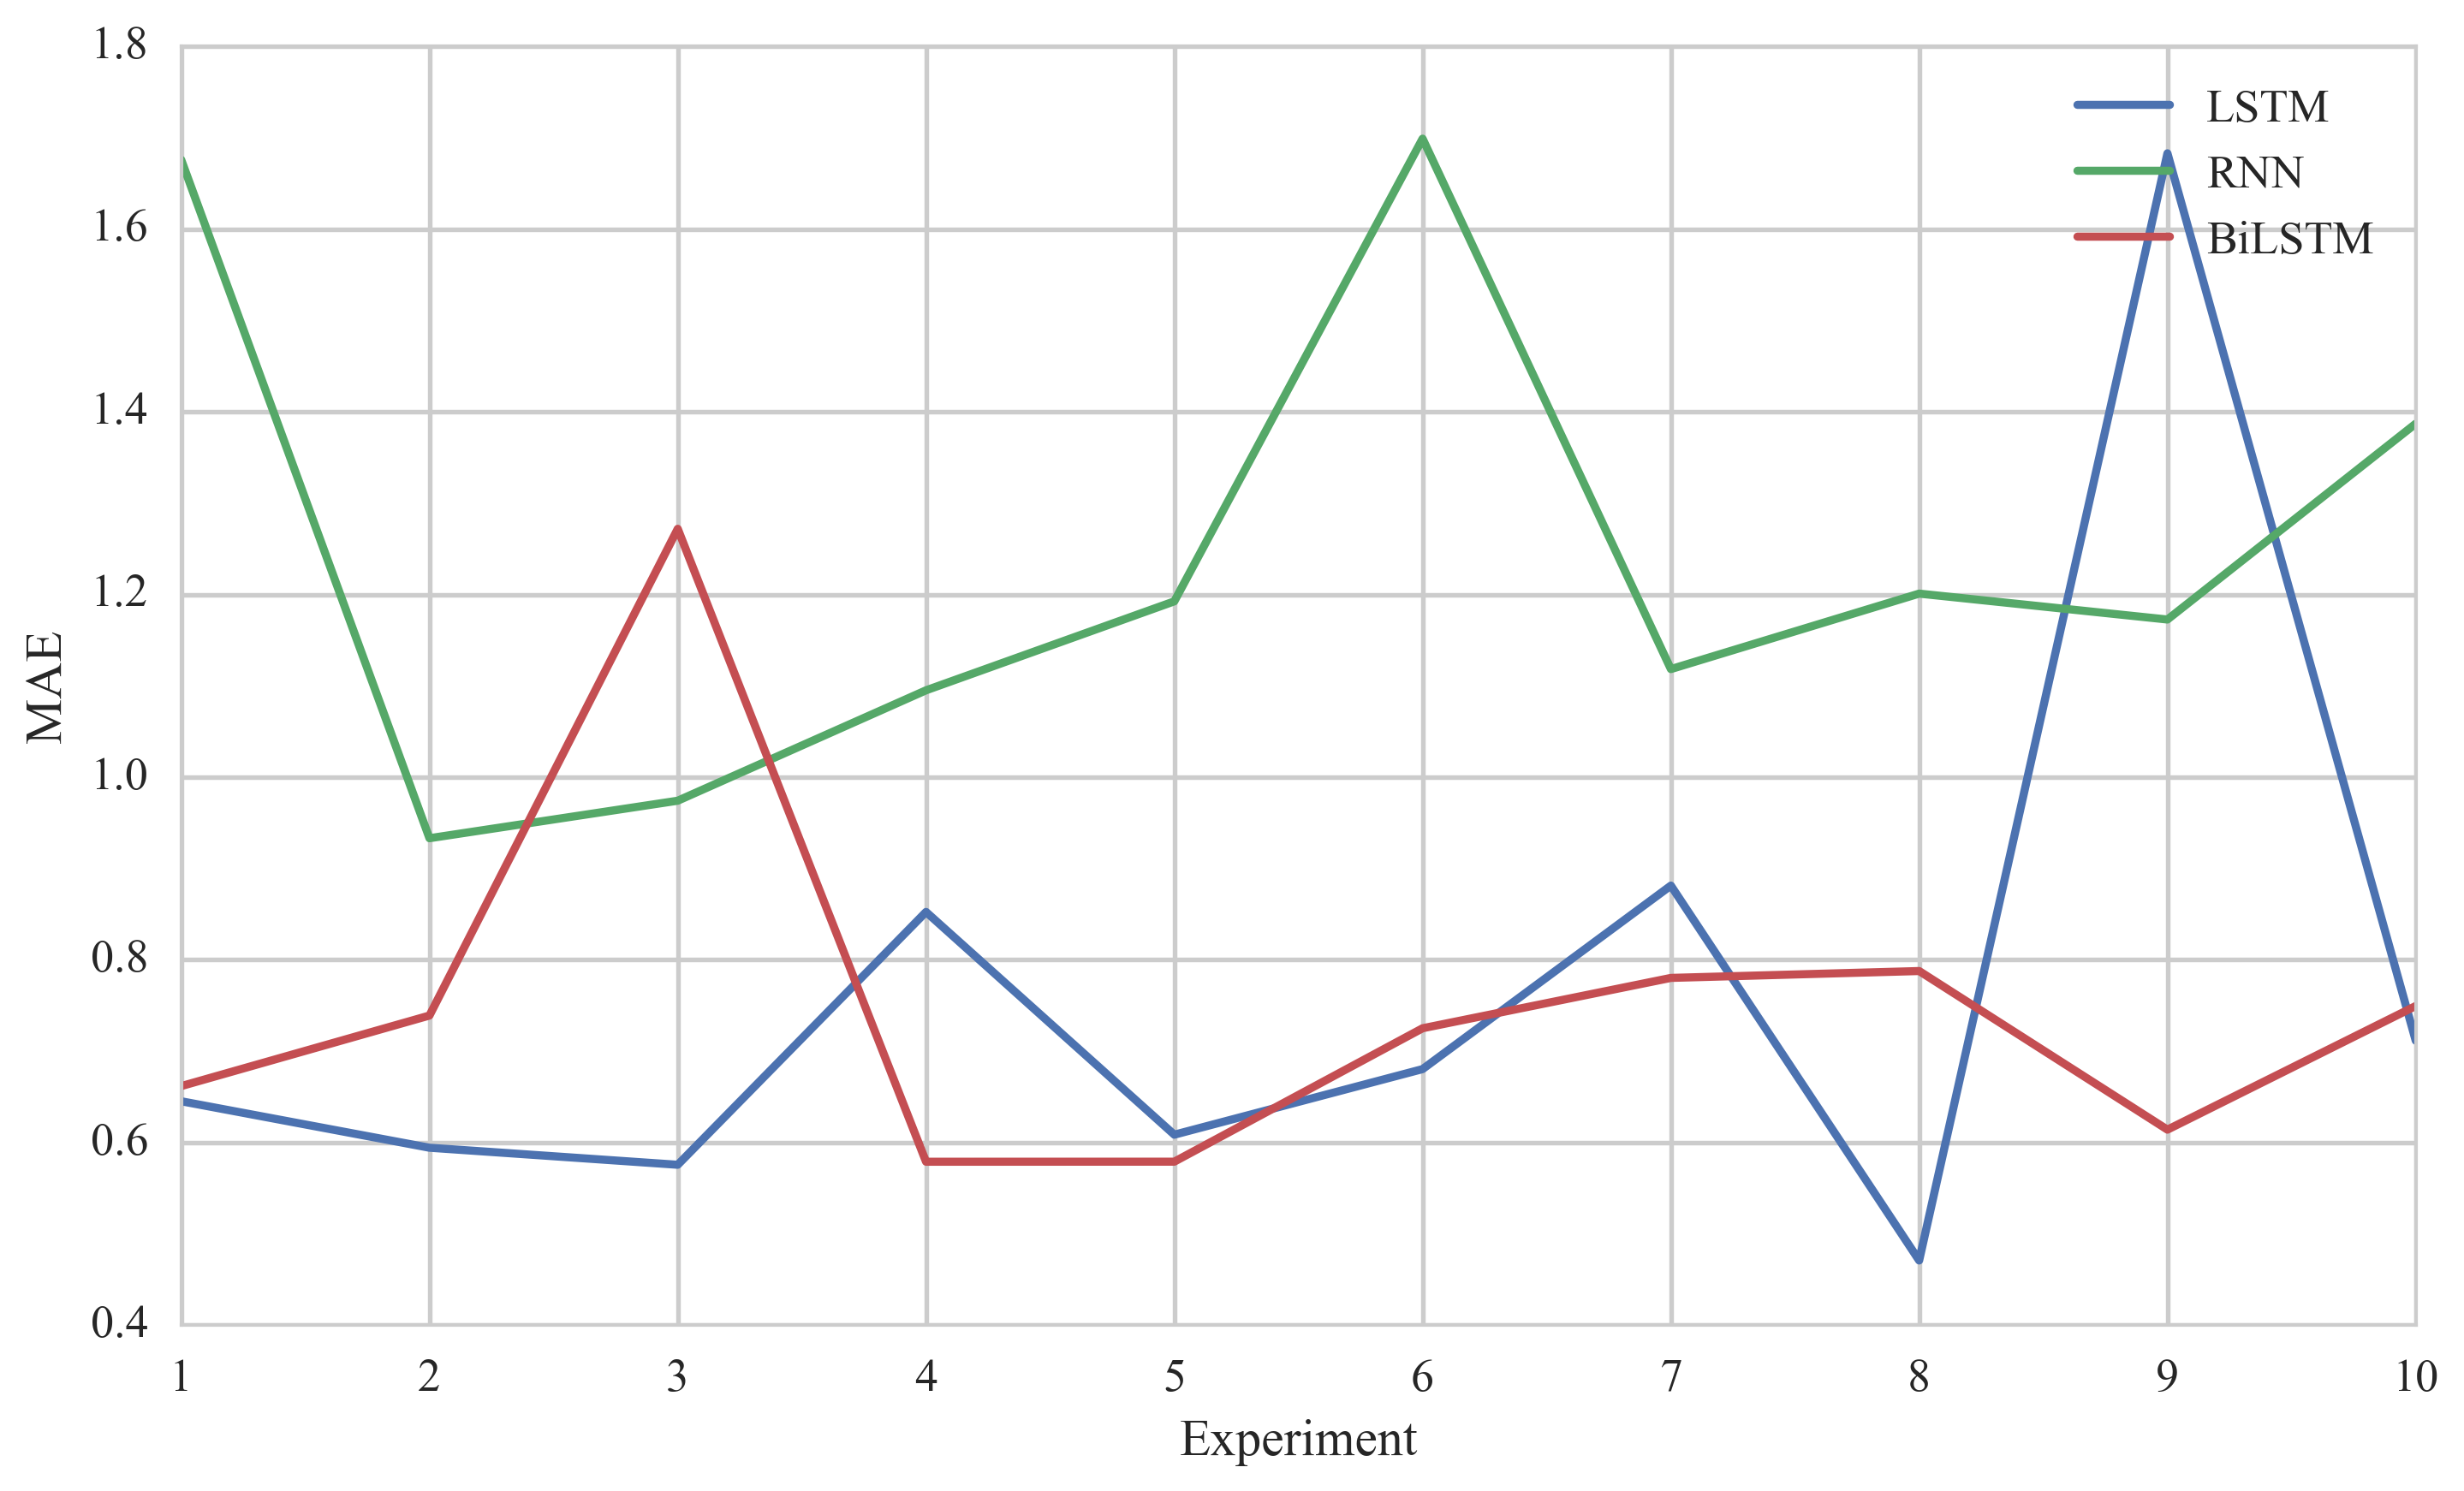

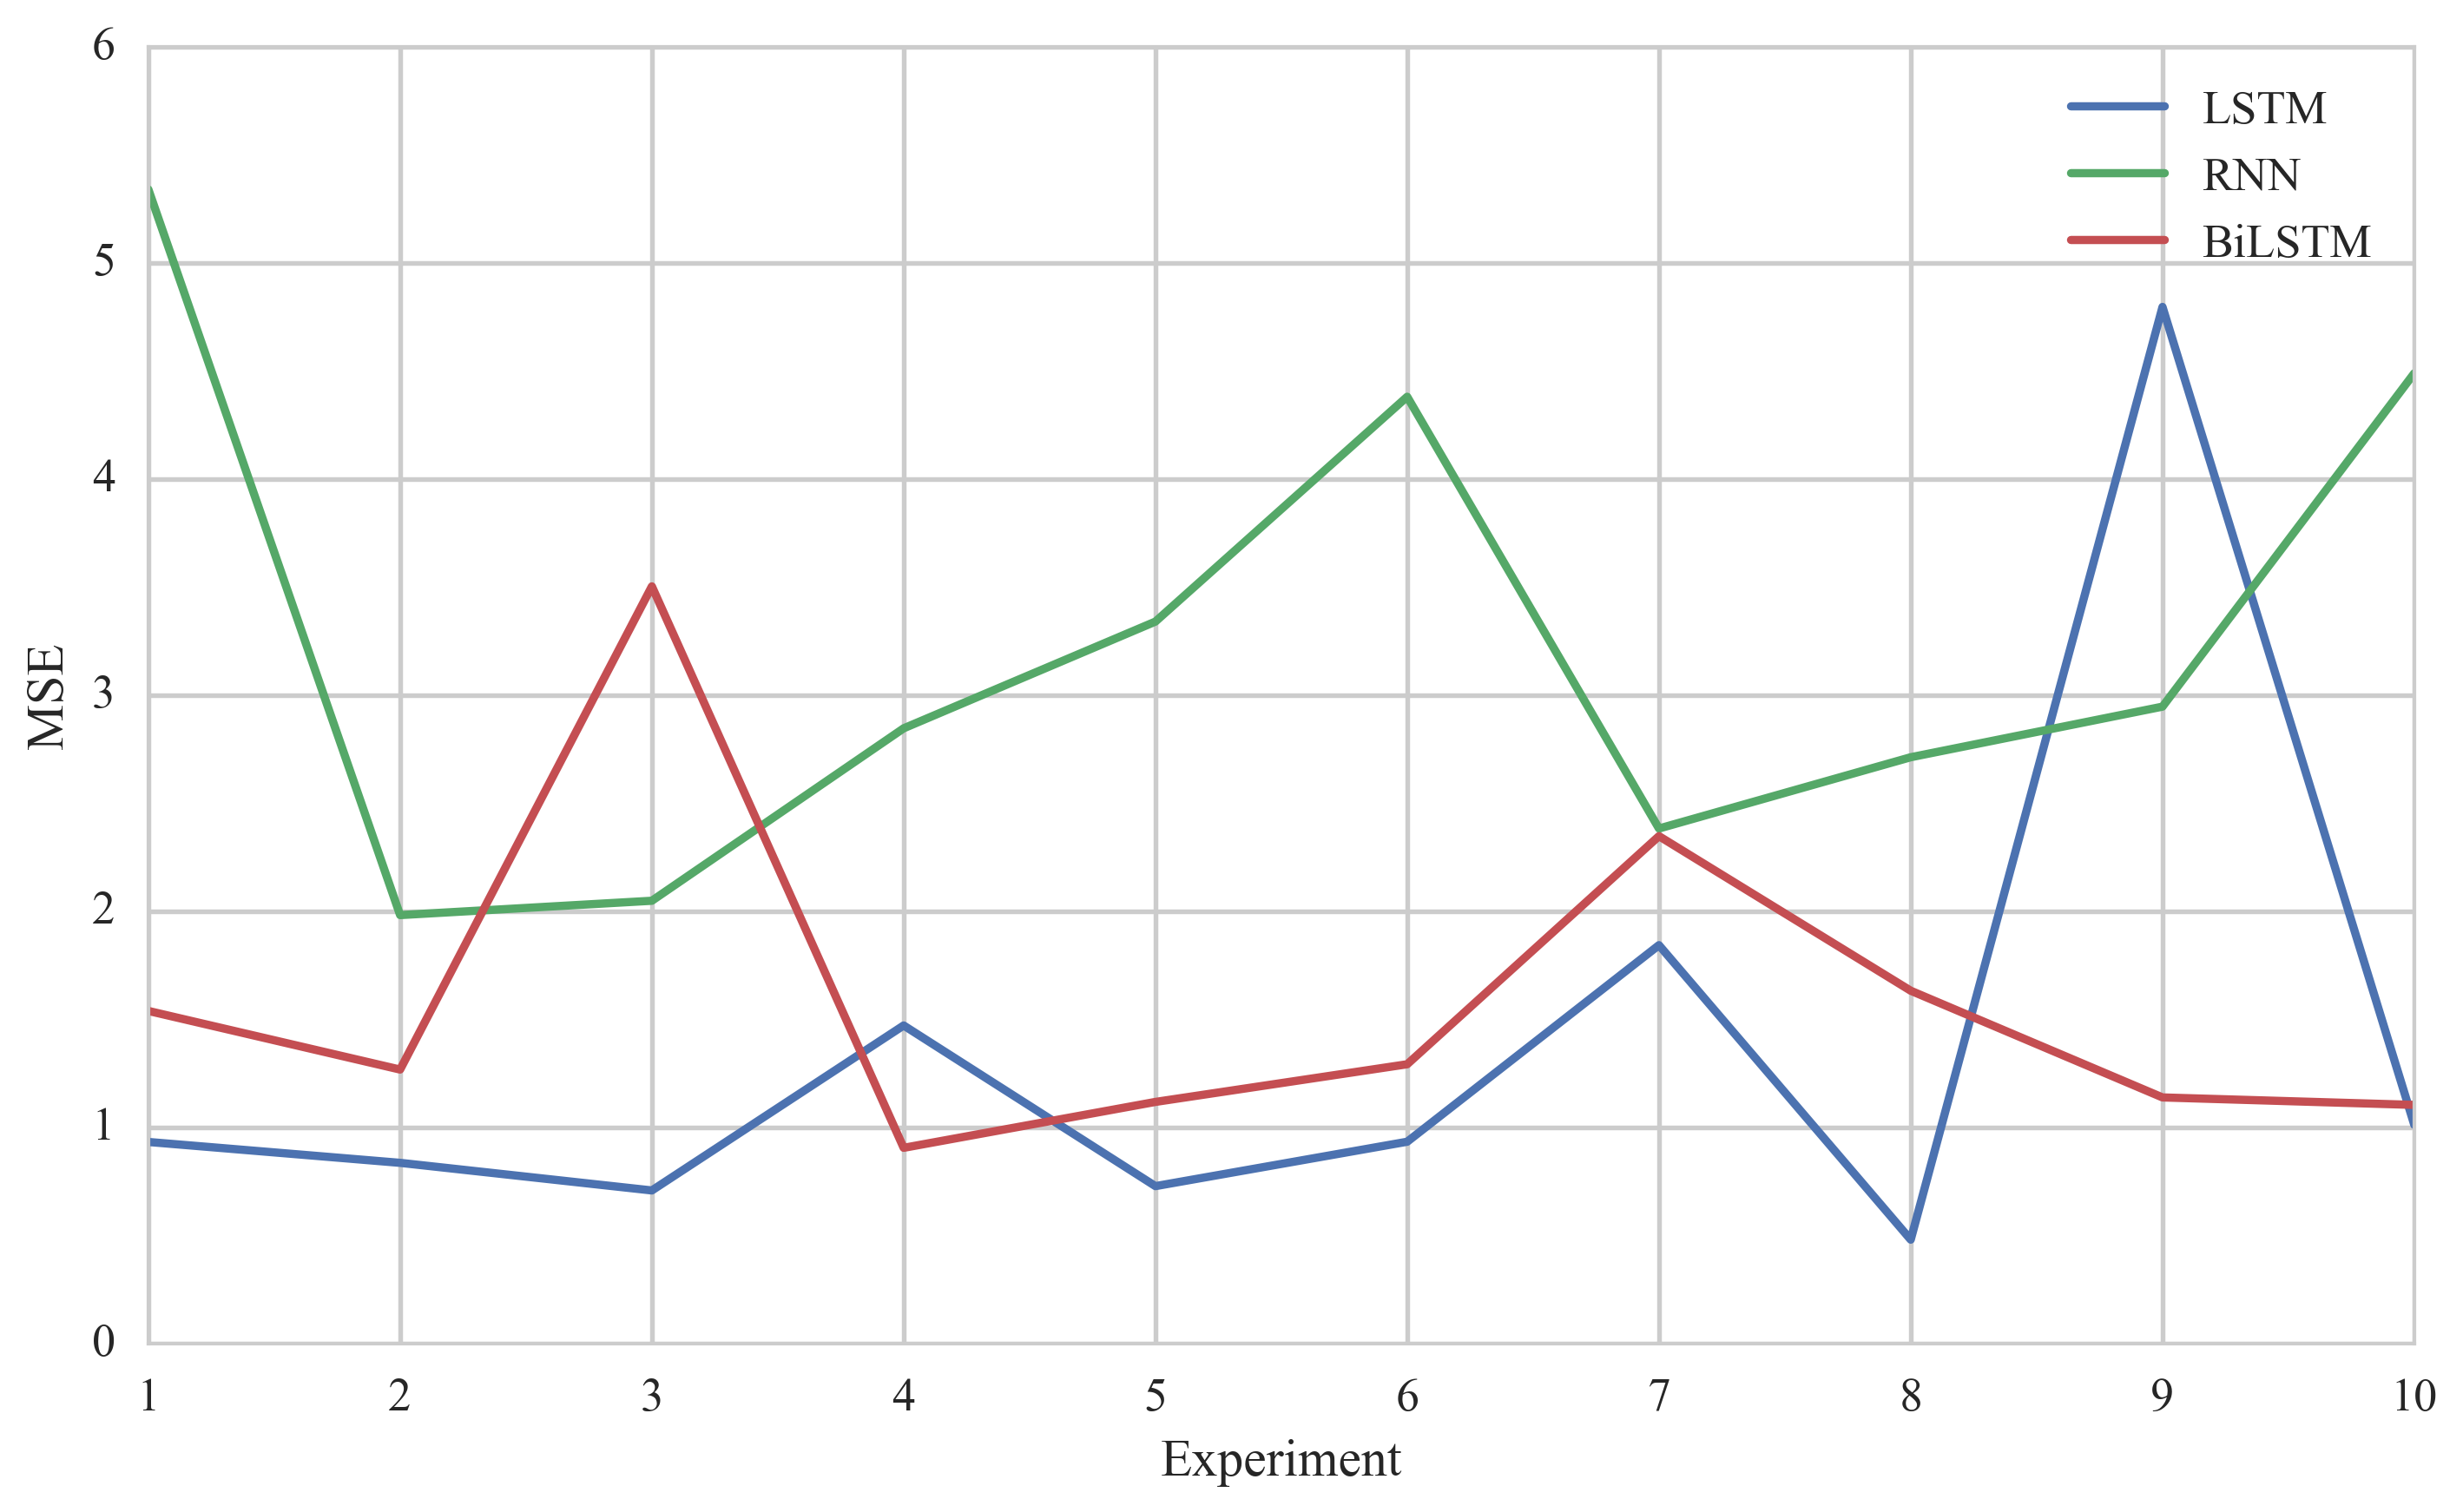

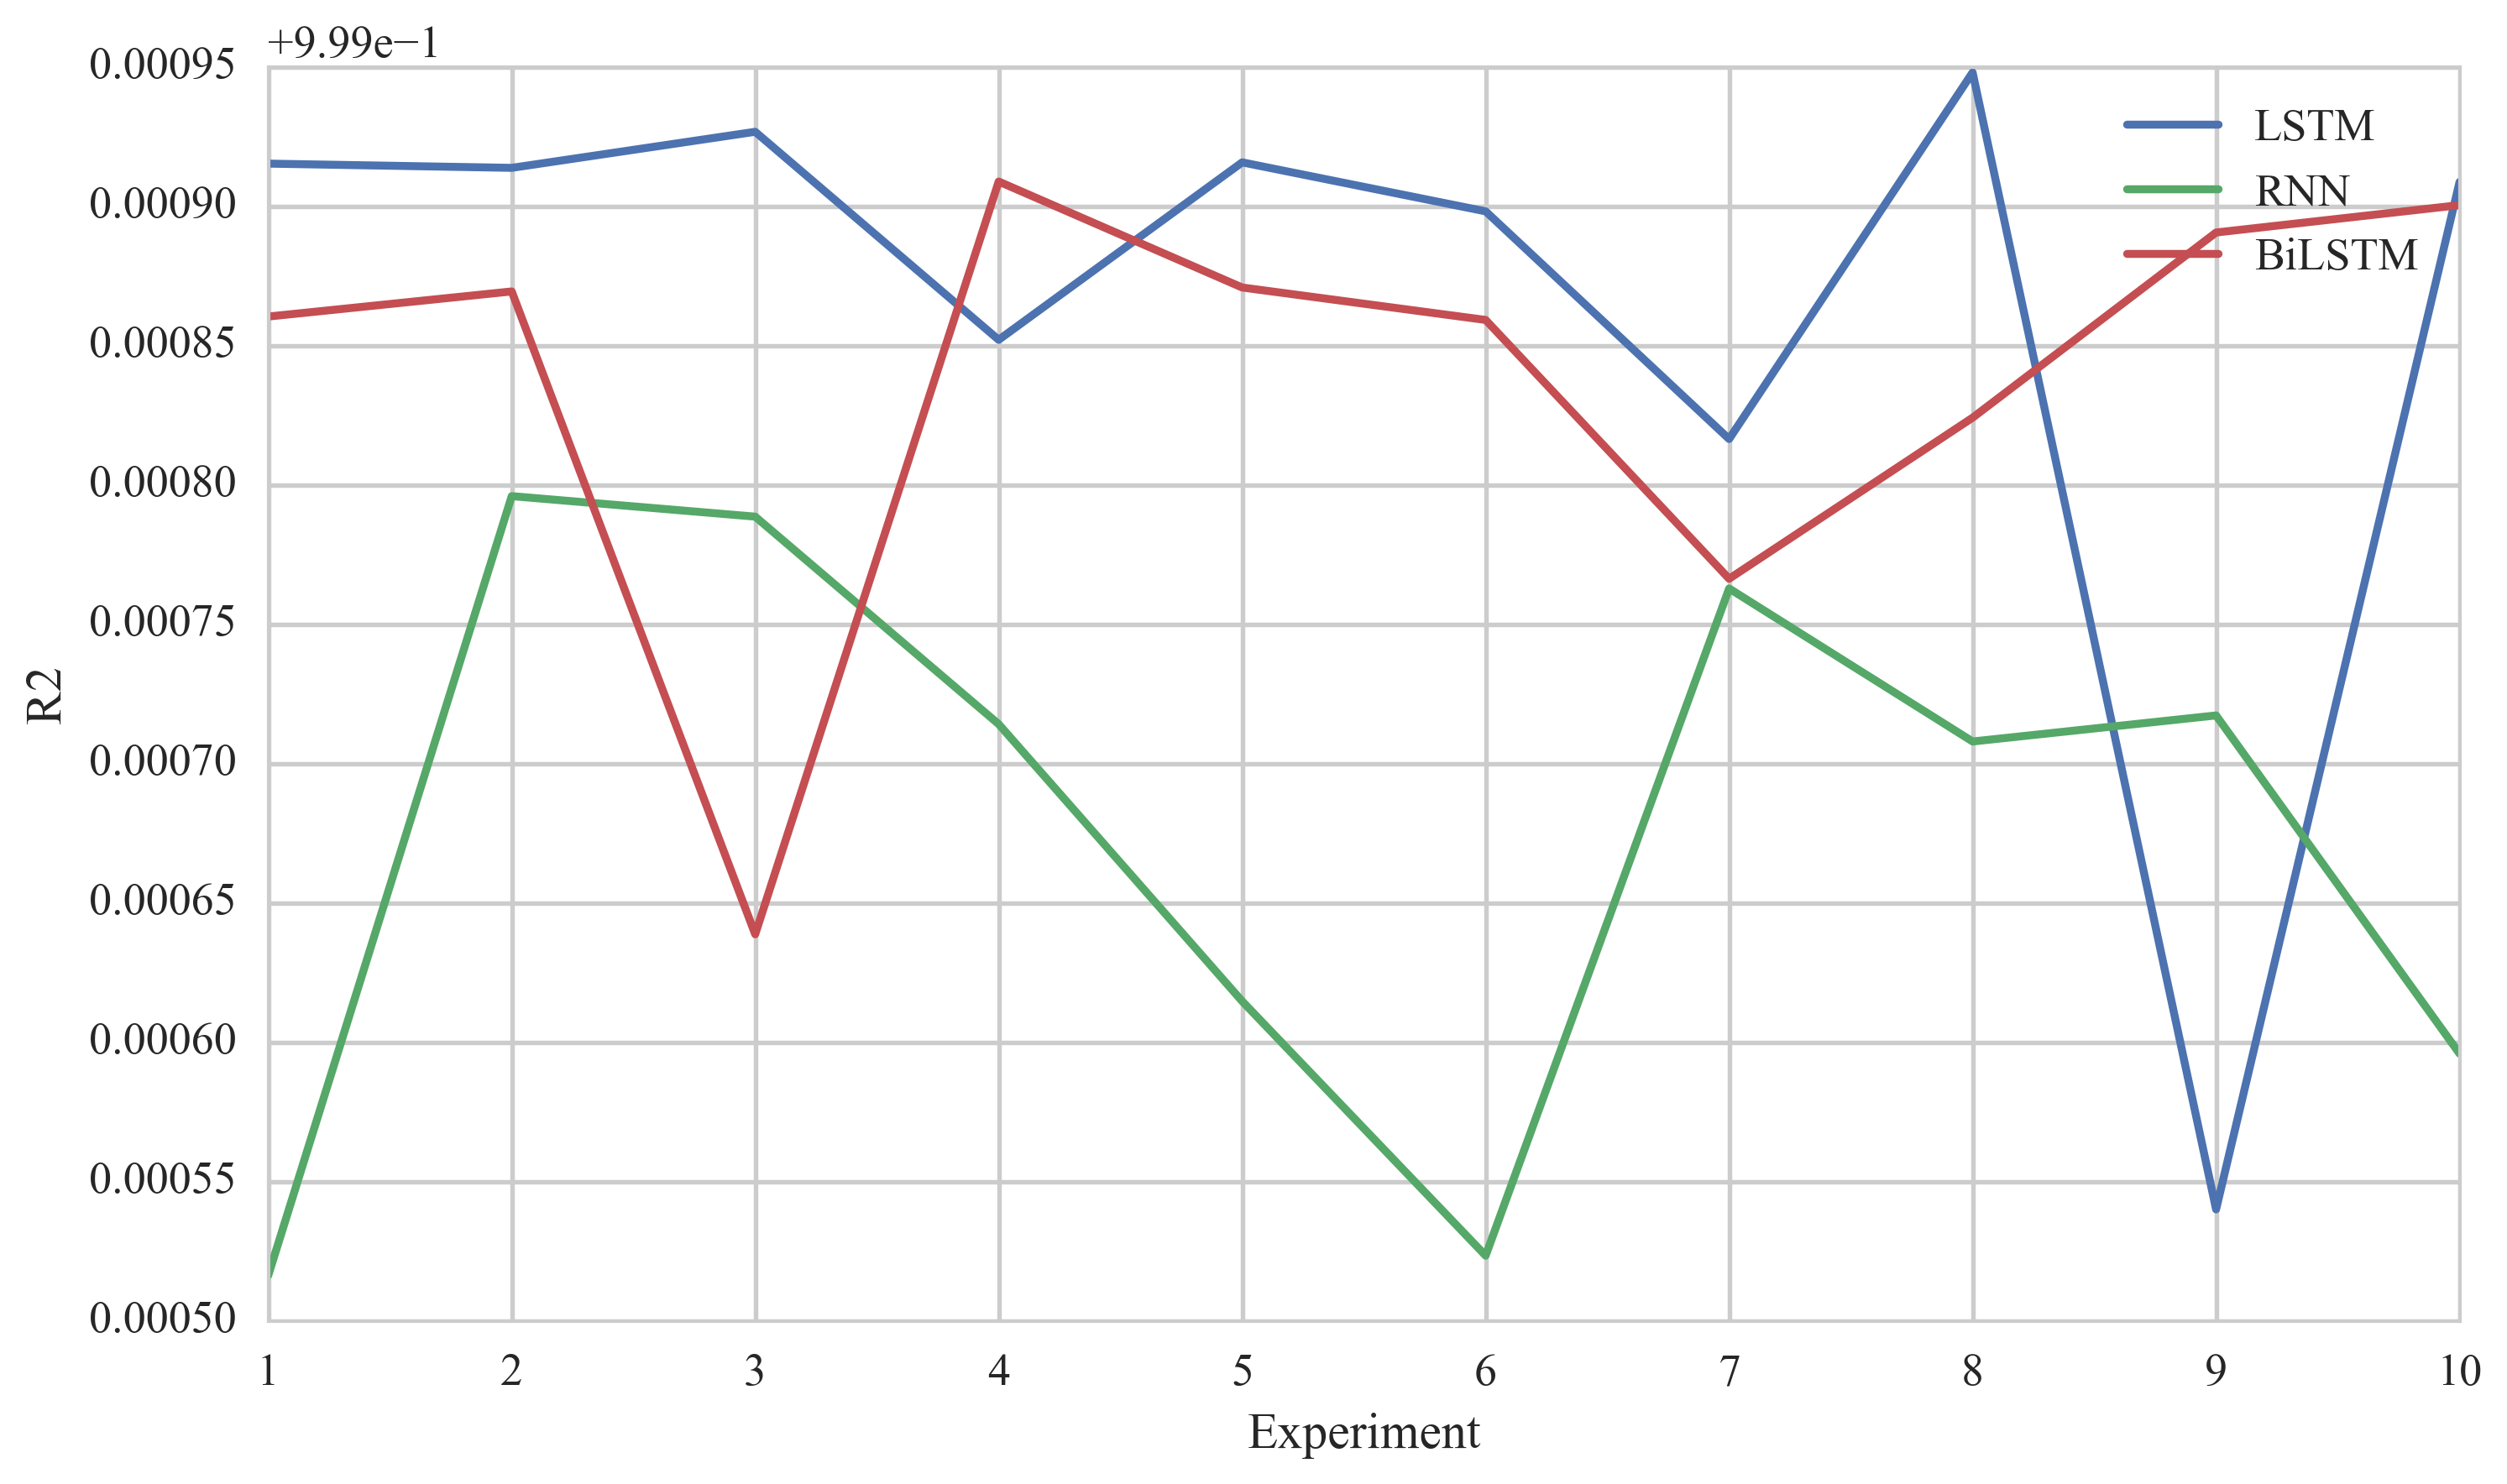

In [149]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_line_plot(metric_data, metric_name):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    for model_type, data in metric_data.items():
        ax.plot([i+1 for i in range(len(data[metric_name]))], data[metric_name], label=model_type)

    ax.set_xlabel('Experiment')
    ax.set_ylabel(metric_name)
    #ax.set_title(f'{metric_name} vs. Experiment')
    ax.legend()
    
    # Set font to sans-serif
    plt.rcParams['font.sans-serif'] = 'Times New Roman'
    
    # Add grid lines
    ax.grid(True)
    
    # Ensure x-axis ticks are integers
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Save the plot
    plt.savefig(f'{metric_name.lower()}_plot.svg',  bbox_inches='tight')
    plt.show()

# Usage:
for metric in metrics:
    plot_line_plot(line_plot_data, metric)


In [ ]:
line_plot_data

In [ ]:
sequence_evaluation_results

{'LSTM': array([0.65696769, 0.8202696 , 0.96625631, 1.08342071, 1.08878692,
        1.11338412, 1.20746964, 1.08106399, 1.01350027, 0.60135803]),
 'BiLSTM': array([0.59575666, 0.76045722, 0.81944638, 0.90216804, 0.83820477,
        0.84335603, 1.1489387 , 1.1026844 , 2.15271275, 2.54543915]),
 'RNN': array([0.90357434, 1.29703048, 1.76261048, 2.02327697, 2.14172045,
        2.32809341, 2.52577953, 2.13061324, 2.03325977, 1.60265961])}

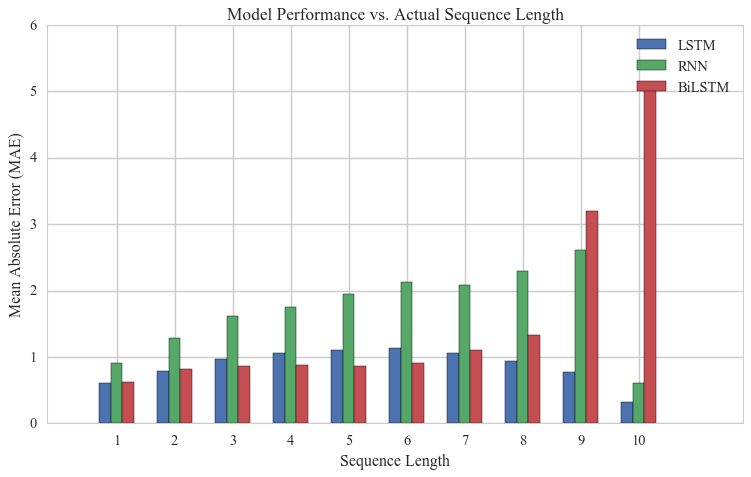

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
x = np.arange(1, max_sequence_length + 1)  # X-axis values (sequence lengths)

# Define the width of the bars
bar_width = 0.2

for i, (model_type, mae_values) in enumerate(sequence_evaluation_results.items()):
    valid_mae_values = [mae for mae in mae_values if mae is not None]  # Filter out None values
    valid_x = x[:len(valid_mae_values)]
    plt.bar(valid_x + i * bar_width, valid_mae_values, width=bar_width, label=model_type)

plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Performance vs. Actual Sequence Length')
plt.xticks(x + bar_width * (len(sequence_evaluation_results.keys()) - 1) / 2, x)  # Adjust the x-axis ticks
plt.legend()
plt.show()


111/111 [==============================] - 1s 8ms/step
MAE After Permutition of AgeAtCalvingInDays : 0.425852835757319
111/111 [==============================] - 1s 9ms/step
MAE After Permutition of AverageBodyScore : 0.4352752926240786
111/111 [==============================] - 1s 8ms/step
MAE After Permutition of AverageMotionScore : 0.42705852004001477
111/111 [==============================] - 1s 9ms/step
MAE After Permutition of InbreedingCoefficient : 0.43344470703703886
111/111 [==============================] - 1s 8ms/step
MAE After Permutition of StillBirth : 0.4234205196887
111/111 [==============================] - 1s 9ms/step
MAE After Permutition of Abortion : 0.4322011153927367
111/111 [==============================] - 1s 8ms/step
MAE After Permutition of MultiBirth : 0.4256867138606044
111/111 [==============================] - 1s 9ms/step
MAE After Permutition of NaturalBreeding : 0.43456070061464563
111/111 [==============================] - 1s 8ms/step
MAE After Perm

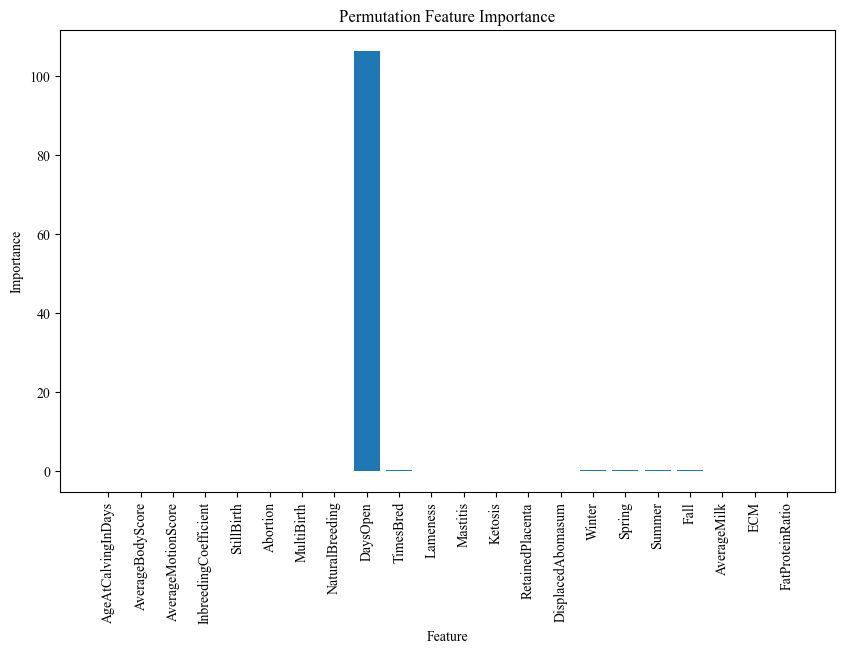

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assume X_test and y_test are your test data
# Assume model is your trained LSTM model
model = models['BiLSTM']
# Compute the baseline performance of the model
baseline_mae = mean_absolute_error(y_test, model.predict(X_test))

# Initialize an array to hold the feature importances
feature_importances = np.zeros(X_test.shape[2])

# Loop over the features
for i in range(X_test.shape[2]):
    # Make a copy of the test data
    X_test_permuted = X_test.copy()

    # Permute the values of the feature
    for j in range(X_test.shape[1]):
        np.random.shuffle(X_test_permuted[:, j, i])

    # Compute the performance of the model on the permuted data
    mae_permuted = mean_absolute_error(y_test, model.predict(X_test_permuted))

    print(f"MAE After Permutition of {feature_columns[i]} : {mae_permuted}")

    # The feature importance is the decrease in performance
    feature_importances[i] =  mae_permuted - baseline_mae

# Plot the feature importances
# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(feature_columns, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation='vertical')  # Rotate feature names for readability
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Display the DataFrame
df_importances

,Feature,Importance
8,DaysOpen,106.353773
9,TimesBred,0.147990
17,Summer,0.139877
15,Winter,0.130902
18,Fall,0.106968
16,Spring,0.102051
1,AverageBodyScore,0.010395
7,NaturalBreeding,0.009680
3,InbreedingCoefficient,0.008564
20,ECM,0.007819


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import plotly.graph_objects as go

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', score)

# Use the model to make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Median Absolute Error (MedAE):', medae)
print('R-squared (R2):', r2)



111/111 [==============================] - 2s 11ms/step - loss: 0.4249 - mean_absolute_error: 0.4249
Test loss: [0.4248802661895752, 0.4248802661895752]
111/111 [==============================] - 1s 9ms/step
Mean Absolute Error (MAE): 0.42488045125908613
Mean Squared Error (MSE): 0.3827163135901189
Median Absolute Error (MedAE): 0.27849578857421875
R-squared (R2): 0.9999655778659636


In [ ]:
# Round the prediction values to natural numbers
lstm_pred_rounded = np.round(models['LSTM'].predict(X_test).flatten())
bi_lstm_pred_rounded = np.round(models['BiLSTM'].predict(X_test).flatten())

111/111 [==============================] - 1s 8ms/step


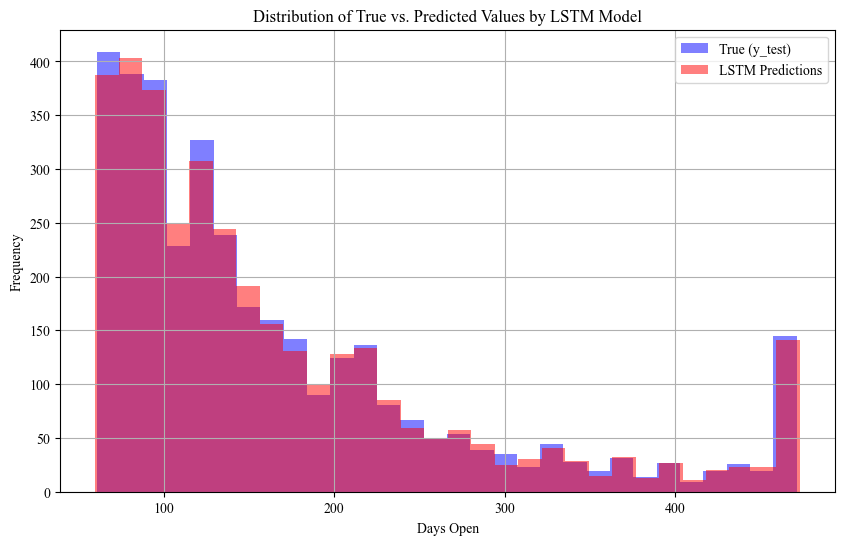

In [ ]:
# Assuming y_test, lstm_pred, and bilstm_pred are numpy arrays
plt.figure(figsize=(10, 6))

# Plot the distribution of y_test in blue
plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='True (y_test)')

# Plot the distribution of LSTM predictions in red
plt.hist(lstm_pred_rounded, bins=30, alpha=0.5, color='red', label='LSTM Predictions')



plt.title('Distribution of True vs. Predicted Values by LSTM Model')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


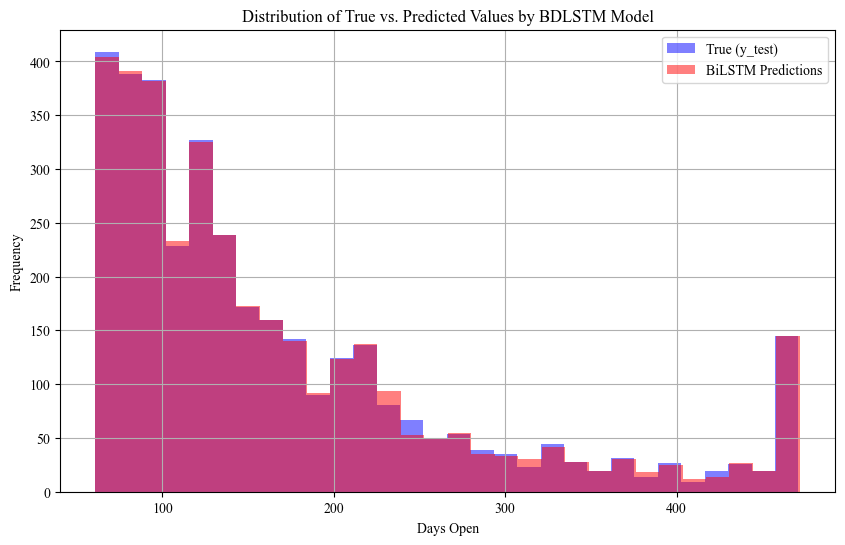

In [ ]:
# Assuming y_test, lstm_pred, and bilstm_pred are numpy arrays
plt.figure(figsize=(10, 6))

# Plot the distribution of y_test in blue
plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='True (y_test)')

# Plot the distribution of LSTM predictions in red
plt.hist(bi_lstm_pred_rounded, bins=30, alpha=0.5, color='red', label='BiLSTM Predictions')



plt.title('Distribution of True vs. Predicted Values by BDLSTM Model')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


 10/159 [>.............................] - ETA: 0s

159/159 [==============================] - 1s 6ms/step


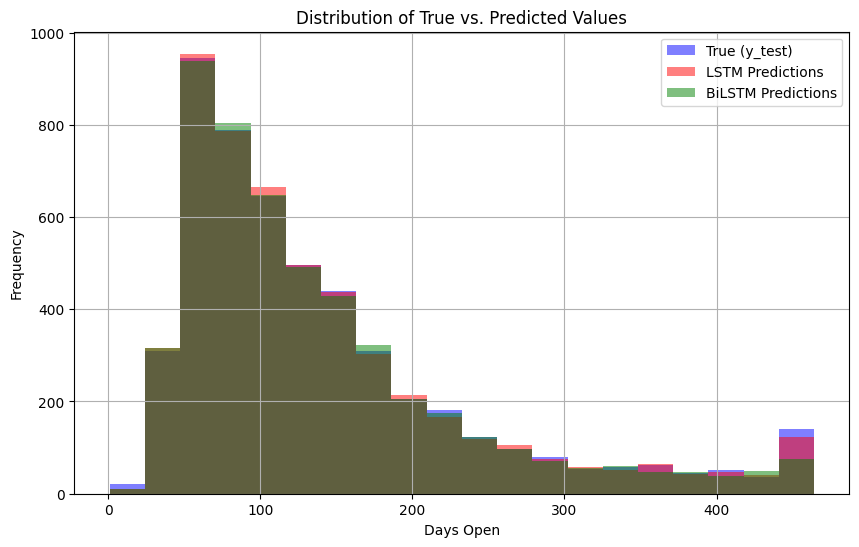

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Round the prediction values to natural numbers
lstm_pred_rounded = np.round(models['LSTM'].predict(X_test).flatten())
bi_lstm_pred_rounded = np.round(models['BiLSTM'].predict(X_test).flatten())

# Assuming y_test, lstm_pred, and bilstm_pred are numpy arrays
plt.figure(figsize=(10, 6))

# Plot the distribution of y_test in blue
plt.hist(y_test, bins=20, alpha=0.5, color='blue', label='True (y_test)', histtype='bar')

# Define the bin edges for better alignment
bin_edges = np.histogram(y_test, bins=20)[1]

# Calculate width for each bin
bin_width = bin_edges[1] - bin_edges[0]

# Plot the distribution of LSTM predictions in red
plt.hist(lstm_pred_rounded, bins=bin_edges, alpha=0.5, color='red', label='LSTM Predictions', histtype='bar', width=bin_width)

# Plot the distribution of BiLSTM predictions in green
plt.hist(bi_lstm_pred_rounded, bins=bin_edges, alpha=0.5, color='green', label='BiLSTM Predictions', histtype='bar', width=bin_width)

plt.title('Distribution of True vs. Predicted Values')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


C:\Users\gheys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


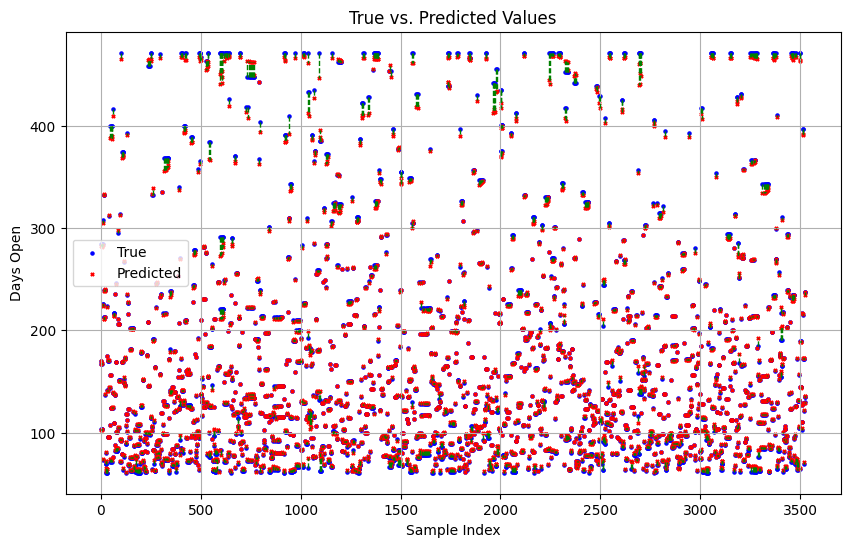

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are numpy arrays
x_values = np.arange(len(y_test))

# Round the prediction values to natural numbers
y_pred_rounded = np.round(y_pred.flatten())

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot true values in blue with smaller dots (s parameter)
plt.scatter(x_values, y_test, label='True', color='blue', marker='o', s=5)

# Plot predicted values (rounded) in red with smaller dots (s parameter)
plt.scatter(x_values, y_pred_rounded, label='Predicted', color='red', marker='x', s=5)

# Draw lines connecting true and predicted values
for x, yt, yp in zip(x_values, y_test, y_pred_rounded):
    plt.plot([x, x], [yt, yp], color='green', linestyle='--', linewidth=1)

plt.title('True vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Days Open')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:

# Distribution of true values and predicted values
fig4 = go.Figure()

# Plot histogram of true values in blue
fig4.add_trace(go.Histogram(x=y_test, nbinsx=20, name='True', marker=dict(color='blue'), opacity=0.7))

# Plot histogram of predicted values in red
fig4.add_trace(go.Histogram(x=y_pred.flatten(), nbinsx=20, name='Predicted', marker=dict(color='red'), opacity=0.7))

fig4.update_layout(title='Distribution of True vs. Predicted Values',
                   xaxis_title='Days Open',
                   yaxis_title='Frequency',
                   barmode='overlay')

fig4.update_traces(opacity=0.75)


fig4.show()


In [ ]:
print(y_pred.squeeze().shape, y_test.squeeze().shape)

(5087,) (5087,)


In [ ]:


# Calculate percentage of predicted values greater than actual test values
greater_count = np.sum(y_pred.squeeze() > y_test.squeeze())
greater_percentage = greater_count / y_pred.squeeze().shape[0] * 100

# Calculate percentage of predicted values lower than actual test values
lower_count = np.sum(y_pred.squeeze() < y_test.squeeze())
lower_percentage = lower_count / y_pred.squeeze().shape[0] * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=['Greater', 'Lower'], y=[greater_percentage, lower_percentage])])
fig.update_layout(title='Percentage of Predicted Values Greater/Lower Than Actual Test Values')
fig.show()